In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.linalg import eig, eigh
from scipy.linalg import null_space
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import curve_fit
from scipy.integrate import simps 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.widgets import Slider

In [2]:
def small_FCC_lattice(a):
    
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    z = np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = a*np.array([
        [0, 0, 0],  # Corner atom
        [1/2, 1/2, 0],  # Face center (x-y plane)
        [1/2, 0, 1/2],  # Face center (x-z plane)
        [0, 1/2, 1/2],  # Face center (y-z plane)
        [1, 1/2, 1/2],
        [1/2, 1, 1/2],
        [1/2, 1/2, 1],
        x, y, z, x+y, x+z, y+z,
        [1, 1, 1],  
        ])
    
    # List positions for second FCC points which lie inside first FCC unit cell
    fcc2_positions = offset + a*np.array([
        [0, 0, 0],  # Corner atom
        [1/2, 1/2, 0],  # Face center (x-y plane)
        [1/2, 0, 1/2],  # Face center (x-z plane)
        [0, 1/2, 1/2],  # Face center (y-z plane)
    ])

    R = []
    S = []
    for pos in fcc_positions:
        R.append(pos)
    for pos in fcc2_positions:
        S.append(pos)

    return np.array(R), np.array(S)

In [3]:
def FCC_lattice(a,size):

    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)

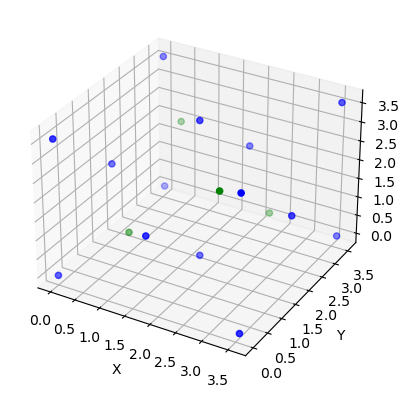

In [160]:
R, S = small_FCC_lattice(3.57)
# R = FCC_lattice(3.57,2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(R[:,0], R[:,1], R[:,2], color='b', marker='o')
ax.scatter(S[:,0], S[:,1], S[:,2], color='g', marker='o')
# ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [7]:
#Check for duplicates (true means no duplicates)
unique_elements = set(tuple(arr) for arr in R)
print(len(unique_elements) == len(R))

True


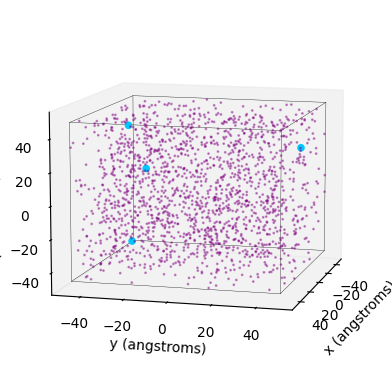

In [4]:
R = FCC_lattice(3.57,13)

prob_C = 1.1*1e-2
prob_e = 30*1e-6
specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
carbons = random.sample(specials, int(len(R)*prob_C))
electrons = [pt for pt in specials if pt not in carbons]

S = np.zeros(R.shape)
T = np.zeros(R.shape)
for pos in carbons:
    S[pos,:] = R[pos,:]
for pos in electrons:
    T[pos,:] = R[pos,:]
    
carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
carbon_pts = np.array(carbon_pts)

e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
e_pts = np.array(e_pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Define custom face and edge colors with different transparency
face_color = (0.5, 0, 0.5, 0.5)  # RGBA for purple with alpha 0.2
edge_color = (0.5, 0, 0.5, 1.0)  # RGBA for purple with full opacity

# ax.scatter(
#     carbon_pts[:, 0], carbon_pts[:, 1], carbon_pts[:, 2],
#     facecolors=face_color,
#     edgecolors=edge_color,
#     marker='o',
#     linewidths=0.5,
#     s=8
# )
# ax.scatter(R[:,0], R[:,1], R[:,2], color='gray', marker='o', alpha = 0.1, s=1)
# ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], facecolors=face_color, edgecolors=edge_color,
#            marker='o',linewidths = 0.5, s=6)
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color = 'purple', marker='o', alpha=0.4, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='#00c8ff', marker='o', alpha = 1, s=20)
ax.grid(False)
# ax.set_box_aspect([1,1,1])  # Equal scaling for x/y/z
ax.set_xlabel('x (angstroms)')
ax.set_ylabel('y (angstroms)')
ax.set_zlabel('z (angstroms)')
# ax.set_xticks([-30, 0, 30])
# ax.set_yticks([-30, 0, 30])
# ax.set_zticks([-30, 0, 30])
from mpl_toolkits.mplot3d import Axes3D  # needed if not already imported

# Light blue background color
bg_color = '#e6e6e6'

ax.xaxis.pane.set_facecolor(bg_color)
ax.yaxis.pane.set_facecolor(bg_color)
ax.zaxis.pane.set_facecolor(bg_color)

# Remove the gray edge lines (optional, but cleaner)
ax.xaxis.pane.set_edgecolor(bg_color)
ax.yaxis.pane.set_edgecolor(bg_color)
ax.zaxis.pane.set_edgecolor(bg_color)

# Get bounding box limits
x_min, x_max = R[:,0].min(), R[:,0].max()
y_min, y_max = R[:,1].min(), R[:,1].max()
z_min, z_max = R[:,2].min(), R[:,2].max()

# Define cube corners
corners = [
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max]
]

# Define the 12 edges to connect
edges = [
    (0,1), (1,2), (2,3), (3,0),  # bottom face
    (4,5), (5,6), (6,7), (7,4),  # top face
    (0,4), (1,5), (2,6), (3,7)   # vertical edges
]

# Plot cube edges
for start, end in edges:
    x = [corners[start][0], corners[end][0]]
    y = [corners[start][1], corners[end][1]]
    z = [corners[start][2], corners[end][2]]
    ax.plot(x, y, z, color='black', linewidth=0.25)


ax.view_init(elev=10, azim=15)

plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Lattice1.svg", transparent=True)
# fig.savefig("C:\\Users\\Suber\\Desktop\\Lattice.pdf", format='pdf', dpi=600)

In [5]:
#Randomly place 13C and electrons in lattice
R = FCC_lattice(3.57,25)

prob_C = 1.1*1e-2
prob_e = 30*1e-6
specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
carbons = random.sample(specials, int(len(R)*prob_C))
electrons = [pt for pt in specials if pt not in carbons]

S = np.zeros(R.shape)
T = np.zeros(R.shape)
for pos in carbons:
    S[pos,:] = R[pos,:]
for pos in electrons:
    T[pos,:] = R[pos,:]
    
carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
carbon_pts = np.array(carbon_pts)

e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
e_pts = np.array(e_pts)

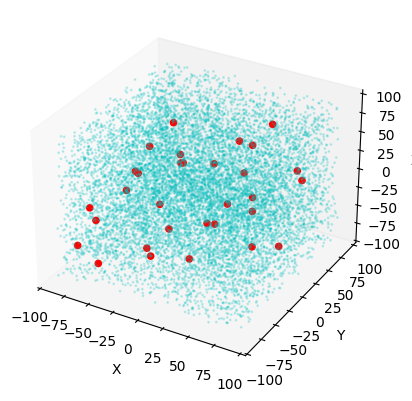

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [9]:
#mean nearest neighbor carbon distance
all_carbon_distances = cdist(carbon_pts,carbon_pts)
np.fill_diagonal(all_carbon_distances, np.inf)
nn_carbon_distance = np.min(all_carbon_distances, axis=1)
average_nn_carbon = np.mean(nn_carbon_distance)
std_nn_carbon = np.std(nn_carbon_distance)
print('average nearest neighbor distance = ', average_nn_carbon, 'angstroms')
print('standard deviation = ', std_nn_carbon)

average nearest neighbor distance =  4.581163480685325 angstroms
standard deviation =  1.640403001842795


In [71]:
#mean nearest neighbor electron distance
all_electron_distances = cdist(e_pts,e_pts)
np.fill_diagonal(all_electron_distances, np.inf)
nn_electron_distance = np.min(all_electron_distances, axis=1)
average_nn_electron = np.mean(nn_electron_distance)
print(average_nn_electron, 'angstroms')

36.05802762724084 angstroms


In [165]:
#CC dipolar coupling with average nearest neighbor distance
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28024.951e6 #Hz/T
r1 = average_nn_carbon*1e-10
D_CC = 2*np.pi*(mu_0*gamma_C*gamma_C*hbar)/(4*np.pi*(r1**3))
print(D_CC, 'Hz')

74.11330081223332 Hz


In [166]:
#ee dipolar coupling with average nearest neighbor distance
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28.024951e9 #Hz/T
r2 = average_nn_electron*1e-10
D_ee = 2*np.pi*(mu_0*gamma_e*gamma_e*hbar)/(4*np.pi*(r2**3))
print(D_ee*1e-6, 'MHz')

1.5907410041734564 MHz


In [28]:
#wavefunction of NV and P1 both vanish within approximately 2 lattice spacings

In [347]:
# #Calculate distance where dipolar coupling between electron and 13C is equal to D
# D = 250e3
# r3 = ((mu_0*gamma_e*gamma_C*hbar)/(2*(D)))**(1/3)
# print(r3*1e10, 'angstroms')

4.3004494525617805 angstroms


In [167]:
#Calculate spin diffusion barrier radius based on Khutsishvili equation
k_B = 1.38e-23
S = np.tanh((2*np.pi*gamma_e*hbar*9.4)/(2*k_B*100))
r3 = (average_nn_carbon*1e-10)*(S*(gamma_e/gamma_C))**(1/4)
print(r3*1e10, 'angstroms')

16.78279765788592 angstroms


In [31]:
#Carbon-electron coupling at the spin diffusion barrier radius is about 4.5kHz.

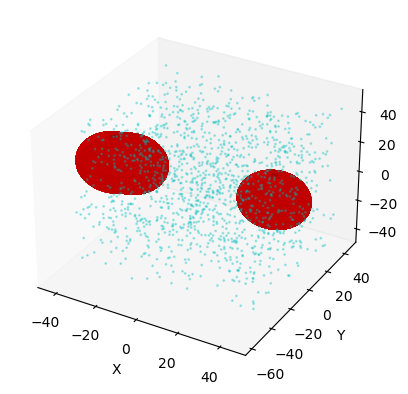

In [168]:
# Define the radius of the spheres
radius = r3*1e10

# Create a meshgrid for the sphere
resolution = 30
u = np.linspace(0, 2 * np.pi, resolution)
v = np.linspace(0, np.pi, resolution)
u, v = np.meshgrid(u, v)

# Parametric equations for the sphere
x_sphere = radius * np.outer(np.cos(u), np.sin(v))
y_sphere = radius * np.outer(np.sin(u), np.sin(v))
z_sphere = radius * np.outer(np.ones(np.size(u)), np.cos(v))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.3, s=1)
# Plot spheres around each point
for pos in range(e_pts.shape[0]):
    ax.plot_surface(e_pts[pos][0] + x_sphere, e_pts[pos][1] + y_sphere, e_pts[pos][2] + z_sphere, color='red', alpha=1)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [169]:
#Calculate the distance between each carbon and the nearest electron and then see if that distance is less than r3
diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
distances = np.linalg.norm(diff, axis=2)
min_distances = np.min(distances, axis=1)

inside_pts = carbon_pts[min_distances < r3*1e10]
outside_pts = carbon_pts[min_distances >= r3*1e10]

In [170]:
N_carbon = carbon_pts.shape[0]
N_e = e_pts.shape[0]
N_bulk = outside_pts.shape[0]
N_core = inside_pts.shape[0]

In [35]:
print((N_core/N_carbon)*100, '% of carbon inside barrier')

6.618181818181817 % of carbon inside barrier


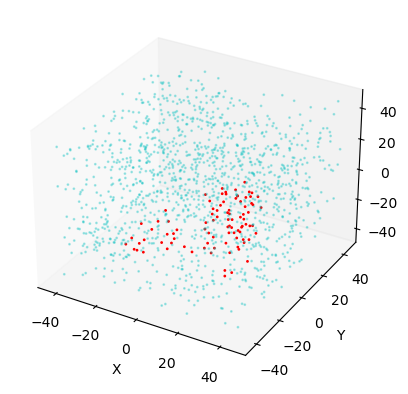

In [36]:
#carbons inside the barrier are plotted in red
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inside_pts[:,0], inside_pts[:,1], inside_pts[:,2], color='r', marker='o', alpha = 1, s=1)
ax.scatter(outside_pts[:,0], outside_pts[:,1], outside_pts[:,2], color='c', marker='o', alpha = 0.3, s=1)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [37]:
def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])

In [38]:
import time
start_time = time.time()

#Calculate R matrix

#Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
#(already similarly done 3 cells above)
diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
distances2 = np.linalg.norm(diff2, axis=2)

R = np.zeros((N_bulk))
rates = np.zeros((N_e))
for carbon in range(N_bulk):
    for e in range(N_e):
        r = distances2[carbon,e]
        angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
        D = 1 - 3*(np.cos(angle))**2 
        C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
        rates[e] = (1/2)*(C**2)*10e-3
    R[carbon] = np.sum(rates)
    rates = np.zeros((N_e))

R = np.diag(R)

end_time = time.time()
print(end_time-start_time)

0.02769637107849121


In [39]:
import time
start_time = time.time()
#Calculate W matrix

#Calculate distances and azimuthal angles between all bulk carbons
#Then calculate diffusion rate matrix W
threshold = 20 #Do not calculate distances and angles for carbons farther apart than threshold (in angstroms)

W = np.zeros((N_bulk, N_bulk))
for pos1 in range(N_bulk):
    for pos2 in range(N_bulk):
        if pos1 != pos2:
            distance = np.linalg.norm(outside_pts[pos1] - outside_pts[pos2])
            if distance < threshold:
                angle = azimuthal_angle(outside_pts[pos1], outside_pts[pos2])
                A = 1 - 3*(np.cos(angle))**2 
                B = ((1/2)*mu_0*gamma_C*gamma_C*hbar*A)/(2*(distance*1e-10)**3)
                W[pos1, pos2] = (1/2)*B**2
                
#Add up entries in each column and subtract from diagonal of W to get conservation of polarization
ratesum = np.sum(W, axis = 0)
W = W - np.diag(ratesum)

end_time = time.time()
print(end_time-start_time)

4.556210041046143


In [187]:
import time
start_time = time.time()

#Calculate W matrix
from scipy.spatial import cKDTree

threshold = 20
tree = cKDTree(outside_pts)
pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

W = np.zeros((N_bulk, N_bulk))
for i, j in pairs:
    diff = outside_pts[i] - outside_pts[j]
    dist = np.linalg.norm(diff)
    unit_vec = diff / dist
    angle = np.arccos(unit_vec[2])

    A = 1 - 3 * (np.cos(angle))**2
    B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
    W[i, j] = 0.5 * B**2
    W[j, i] = 0.5 * B**2  # symmetry

W = W - np.diag(np.sum(W, axis=0))

end_time = time.time()
print(end_time-start_time)

0.21144342422485352


In [186]:
#With periodic boundary conditions

import time
start_time = time.time()

#Calculate W matrix
from scipy.spatial import cKDTree

box_size = 3.57 * (2*12 + 1)

threshold = 20

W_PBC = np.zeros((N_bulk, N_bulk))
for i in range(N_bulk - 1):
    for j in range(i + 1, N_bulk):
        diff = outside_pts[i] - outside_pts[j]
        diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
    #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
    #         print("PBC adjusted a distance!")
        dist = np.linalg.norm(diff)
        if dist > threshold:
                W_PBC[i, j] = 0
                W_PBC[j, i] = 0  # symmetry
        else:    
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W_PBC[i, j] = 0.5 * B**2
            W_PBC[j, i] = 0.5 * B**2  # symmetry

W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

end_time = time.time()
print(end_time-start_time)

5.93414044380188


In [188]:
are_equal = np.array_equal(W, W_PBC)
print(are_equal)

False


In [41]:
import time
start_time = time.time()
# M = W
# M = -R
M = -R
t_pts = 100
T = np.linspace(0, 10e-3, t_pts)
alpha_0 = (1/N_bulk)*np.ones(N_bulk)
alpha = np.zeros((N_bulk, t_pts))

evals, evecs = eigh(M)
V_inv = np.linalg.inv(evecs)

# max_exp = 1000
# evals_clipped = np.clip(evals, -max_exp, max_exp)

V_alpha = V_inv @ alpha_0
for t in range(t_pts):
    alpha[:, t] = evecs @ (np.exp(evals * T[t]) * V_alpha)
    
end_time = time.time()
print(end_time-start_time)

0.09795880317687988


<IPython.core.display.Javascript object>


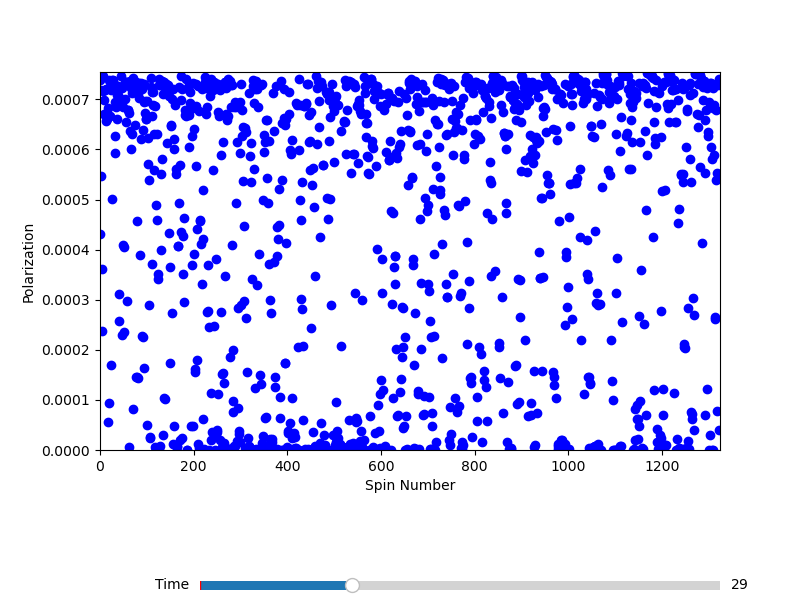

In [964]:
#Plot movie of polarization of each spin as a function of time

%matplotlib notebook

num_spins = N_bulk  # Number of spins
num_times = t_pts  # Number of time points


# Set up the figure and axis with more space for the slider
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size if needed
plt.subplots_adjust(bottom=0.25)  # Adjust bottom to provide space for the slider

# Initial plot (time index = 0)
time_index = 0
sc = ax.scatter(range(num_spins), alpha[:, time_index], c='blue')

ax.set_xlabel("Spin Number")
ax.set_ylabel("Polarization")
ax.set_xlim(0, num_spins - 1)
ax.set_ylim(0, np.max(alpha))

# Create slider for time control
ax_slider = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Time', 0, num_times - 1, valinit=0, valstep=1)

# Update function to update the plot based on the slider value
def update(val):
    time_index = int(slider.val)
    sc.set_offsets(np.column_stack((range(num_spins), alpha[:, time_index])))
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()

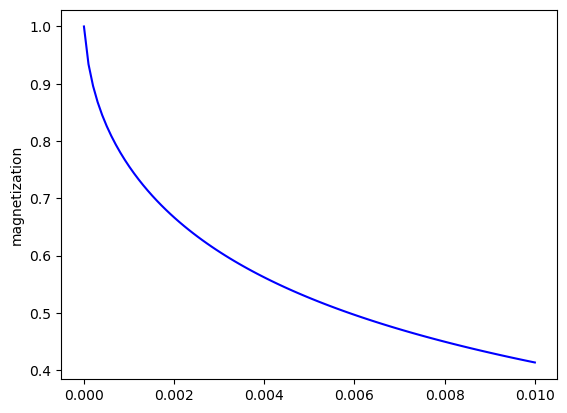

In [42]:
#Plot magnetization as a function of time
P = np.sum(alpha, axis=0)

fig = plt.figure()
plt.plot(T, P, color='b')  
plt.ylabel('magnetization')
plt.show()

In [43]:
#Now want to average over many different lattice configurations
def place_specials(size):
    R = FCC_lattice(3.57,size)

    prob_C = 1.1*1e-2
    prob_e = 30*1e-6
    specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
    carbons = random.sample(specials, int(len(R)*prob_C))
    electrons = [pt for pt in specials if pt not in carbons]

    S = np.zeros(R.shape)
    T = np.zeros(R.shape)
    for pos in carbons:
        S[pos,:] = R[pos,:]
    for pos in electrons:
        T[pos,:] = R[pos,:]

    carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
    carbon_pts = np.array(carbon_pts)

    e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
    e_pts = np.array(e_pts)
    
    return carbon_pts, e_pts



def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])



def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
    diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    min_distances = np.min(distances, axis=1)

    inside_pts = carbon_pts[min_distances < r3*1e10]
    outside_pts = carbon_pts[min_distances >= r3*1e10]

    N_carbon = carbon_pts.shape[0]
    N_e = e_pts.shape[0]
    N_bulk = outside_pts.shape[0]
    N_core = inside_pts.shape[0]
    
    #Calculate R matrix

    #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
    #(already similarly done 3 cells above)
    diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances2 = np.linalg.norm(diff2, axis=2)

    R = np.zeros((N_bulk))
    rates = np.zeros((N_e))
    for carbon in range(N_bulk):
        for e in range(N_e):
            r = distances2[carbon,e]
            angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
            D = 1 - 3*(np.cos(angle))**2 
            C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
            rates[e] = (1/2)*(C**2)*tau_p
        R[carbon] = np.sum(rates)
        rates = np.zeros((N_e))

    R = np.diag(R)
    
    #Calculate W matrix
    from scipy.spatial import cKDTree

    threshold = 20
    tree = cKDTree(outside_pts)
    pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

    W = np.zeros((N_bulk, N_bulk))
    for i, j in pairs:
        diff = outside_pts[i] - outside_pts[j]
        dist = np.linalg.norm(diff)
        unit_vec = diff / dist
        angle = np.arccos(unit_vec[2])

        A = 1 - 3 * (np.cos(angle))**2
        B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
        W[i, j] = 0.5 * B**2 * tau_d
        W[j, i] = 0.5 * B**2 * tau_d# symmetry

    W = W - np.diag(np.sum(W, axis=0))
    
    M = W-R
    return N_bulk, M



def solve_ode(N_bulk, time, alpha_0, M):
    t_pts = len(time)
    alpha = np.zeros((N_bulk, t_pts))

    evals, evecs = eigh(M)
    V_inv = np.linalg.inv(evecs)

    # max_exp = 1000
    # evals_clipped = np.clip(evals, -max_exp, max_exp)

    V_alpha = V_inv @ alpha_0
    for t in range(t_pts):
        alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
    
    return alpha

In [44]:
#Will take many different lattice configurations and calculate the magnetization as a function of time for each of them

import time
iterations = 5
size = 12

T = np.linspace(0,300,100)
P = np.zeros((iterations, len(T)))
start_time = time.time()
for i in range(iterations):
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, 1.1e-6, 8.5e-3)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)


    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P[i,:] = np.sum(alpha, axis=0)

end_time = time.time()
print(end_time-start_time)

8.628903865814209


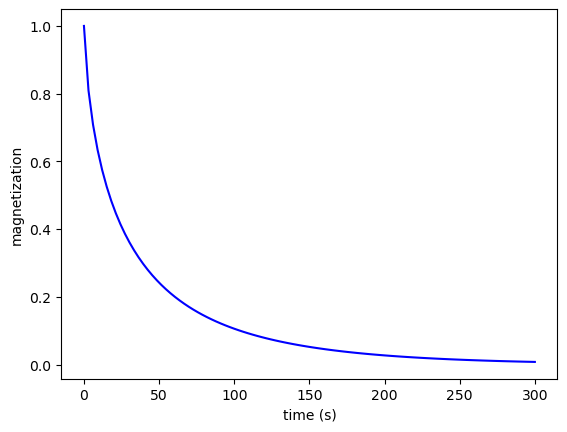

In [45]:
#Plot magnetization as a function of time averaged over many different lattice configurations
P_avg = (np.sum(P, axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

(10, 100)
67.76936626434326


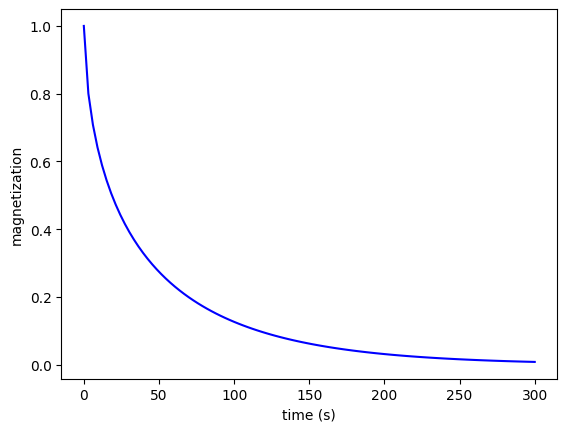

In [46]:
#Run different lattice configurations simultaneously using different CPU cores
from pathos.multiprocessing import ProcessingPool as Pool
import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts


    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])


    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)
        
        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
#                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)
            
                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,300,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 10
inputs = [(2e-8, 2.5e-5)] * iterations

pool = Pool()
pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.linspace(0,300,100)
P_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

<Figure size 640x480 with 0 Axes>

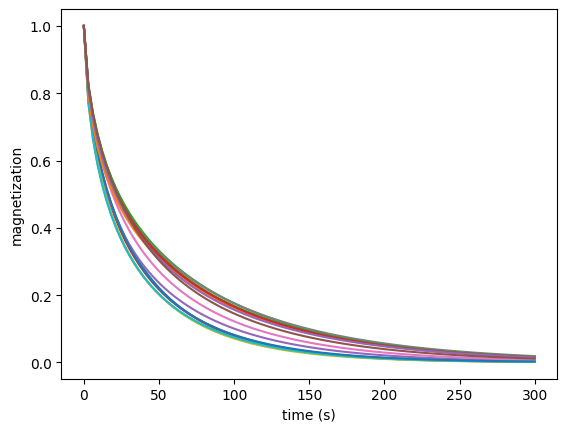

In [37]:
#Show variance in Monte Carlo trajectories

plt.clf()
fig = plt.figure()
P = np.array(results)
for j in range(iterations):
    plt.plot(T, P[j])
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

RMSE product: 0.0024261014299606335


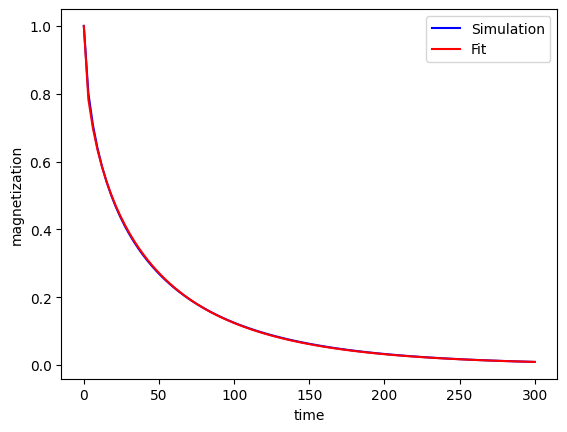

In [38]:
#Fit the data

def product_exp(x, a, b):
    return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

def purely_stretched(x, a):
    return np.exp(-np.sqrt(a*x)) 

def monoexp(x, a):
    return np.exp(-a*x)

# Fit the data
popt, pcov = curve_fit(product_exp, T, P_avg, bounds=([0, 0], [1, 1]))

# # popt = optimal values for a, b, c
# print("Fitted parameters:", popt)
# # Optional: Get standard deviation errors
# perr = np.sqrt(np.diag(pcov))
# print("Parameter errors:", perr)

y_fit = product_exp(T, *popt)
residuals = P_avg - y_fit
rmse_product = np.sqrt(np.mean(residuals**2))
print("RMSE product:", rmse_product)

# Plot the data and the fitted curve
fig = plt.figure()
plt.plot(T, P_avg, color='b', label="Simulation")
plt.plot(T, product_exp(T, *popt), color='red', label="Fit")
# plt.semilogy(np.sqrt(T), P_avg, color='b', label="Simulation")
# plt.semilogy(np.sqrt(T), product_exp(T, *popt), color='red', label="Fit")
plt.legend()
plt.xlabel("time")
plt.ylabel("magnetization")
plt.show()

# popt, pcov = curve_fit(purely_stretched, T, P_avg, bounds=([0], [1]))
# y_fit = purely_stretched(T, *popt)
# residuals = P_avg - y_fit
# rmse_purely_stretched = np.sqrt(np.mean(residuals**2))
# print("RMSE purely stretched:", rmse_purely_stretched)
# fig = plt.figure()
# plt.plot(T, P_avg, color='b', label="Simulation")
# plt.plot(T, purely_stretched(T, *popt), color='red', label="Fit")
# plt.legend()
# plt.xlabel("time")
# plt.ylabel("magnetization")
# plt.show()


# popt, pcov = curve_fit(monoexp, T, P_avg, bounds=([0], [1]))
# y_fit = monoexp(T, *popt)
# residuals = P_avg - y_fit
# rmse_monoexp = np.sqrt(np.mean(residuals**2))
# print("RMSE monoexp:", rmse_monoexp)
# fig = plt.figure()
# plt.plot(T, P_avg, color='b', label="Simulation")
# plt.plot(T, monoexp(T, *popt), color='red', label="Fit")
# plt.legend()
# plt.xlabel("time")
# plt.ylabel("magnetization")
# plt.show()


In [39]:
print('stretched rate =', popt[0]*1e3, '(1/s x 10^-3)', 'monoexp. rate =', popt[1]*1e3, '(1/s x 10^-3)')

stretched rate = 15.790055580531838 (1/s x 10^-3) monoexp. rate = 8.297971269999685 (1/s x 10^-3)


RMSE (Root Mean Square Error): 0.0024261014299606335


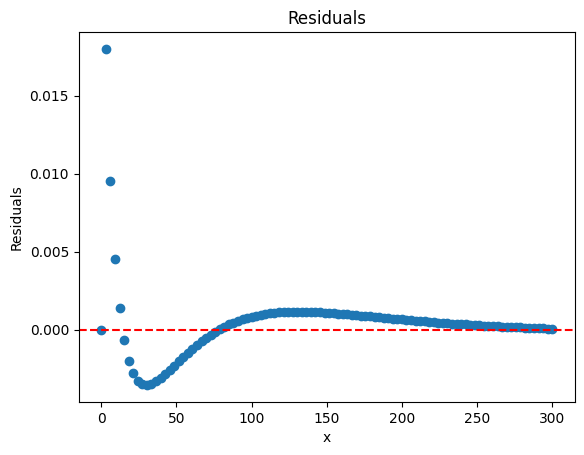

In [40]:
#Calculate the residuals of the fit

y_fit = product_exp(T, *popt)
residuals = P_avg - y_fit

# # Print or inspect residuals
# print("Residuals:", residuals)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(residuals**2))
print("RMSE (Root Mean Square Error):", rmse)

# # Sum of Squared Residuals (SSR)
# ssr = np.sum(residuals**2)
# print("Sum of Squared Residuals (SSR):", ssr)

#Plot residuals
plt.figure()
plt.scatter(T, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals")
plt.xlabel("x")
plt.ylabel("Residuals")
plt.show()


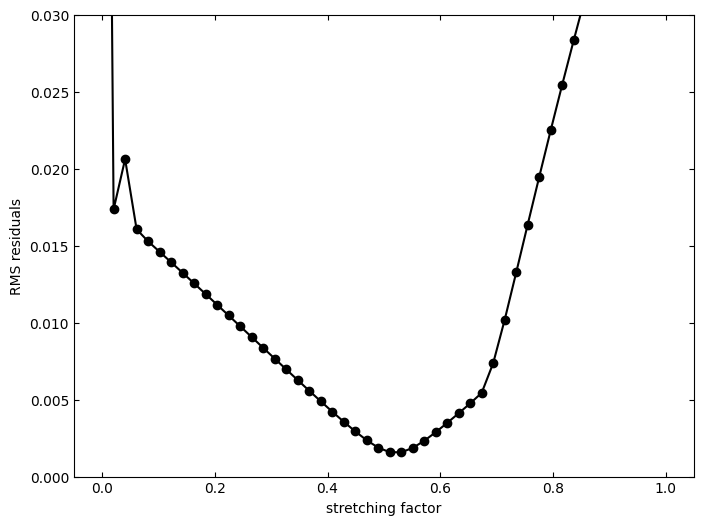

In [48]:
#Calculate residuals for different stretching factors 

stretching_factors = np.linspace(0, 1, 50)
error = np.zeros(len(stretching_factors))
counter = 0
for gamma in stretching_factors:
    def model_func(x, a, b):
        return np.exp(-(a*x)**gamma)*np.exp(-b*x)
    
    popt, pcov = curve_fit(model_func, T, P_avg, bounds=([0, 0], [0.1, 0.1]))
    y_fit = model_func(T, *popt)
    residuals = P_avg - y_fit
    error[counter] = np.sqrt(np.mean(residuals**2))
    counter += 1

fig = plt.figure(figsize = (8, 6))
plt.plot(stretching_factors, error, '-o', color='black')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel("stretching factor")
plt.ylabel("RMS residuals")
plt.ylim((0, 0.03))
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\OptimalStretchFactor.eps", format='eps', dpi=300)

In [1039]:
#Simulate over many different lattice configurations and many different values for the strengths of the paramagnetic
#and dipolar interactions. Then do the fitting as a function of these two strengths

def product_exp(x, a, b):
    return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

tau_p = np.logspace(-7, -5, 3)
tau_d = np.logspace(-3, -1, 3)

stretched = np.zeros((len(tau_p), len(tau_d)))
mono = np.zeros((len(tau_p), len(tau_d)))
rmse = np.zeros((len(tau_p), len(tau_d)))

iterations = 5
size = 12

for k in range(len(tau_p)):
    for j in range(len(tau_d)):
        T = np.linspace(0,300,100)
        P = np.zeros((iterations, len(T)))
        for i in range(iterations):
            carbon_pts, e_pts = place_specials(size)
            N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p[k], tau_d[j])
            alpha_0 = (1/N_bulk)*np.ones(N_bulk)

            alpha = solve_ode(N_bulk, T, alpha_0, M)
            P[i,:] = np.sum(alpha, axis=0)
            
        P_avg = (np.sum(P, axis=0))/iterations

        popt, pcov = curve_fit(product_exp, T, P_avg, bounds=([0, 0], [10, 10]))
        stretched[k, j] = popt[0]
        mono[k, j] = popt[1]
        
        y_fit = product_exp(T, *popt)
        residuals = P_avg - y_fit
        rmse[k, j] = np.sqrt(np.mean(residuals**2))

<IPython.core.display.Javascript object>


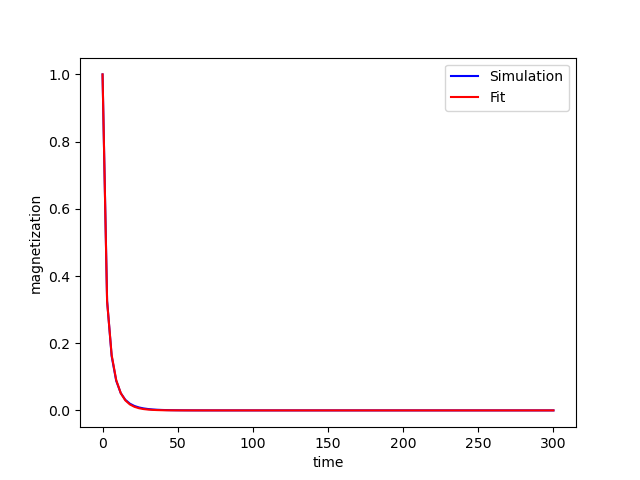

In [1040]:
# Plot the data and the fitted curve
fig = plt.figure()
plt.plot(T, P_avg, color='b', label="Simulation")
plt.plot(T, product_exp(T, *popt), color='red', label="Fit")
plt.legend()
plt.xlabel("time")
plt.ylabel("magnetization")
plt.show()

<IPython.core.display.Javascript object>


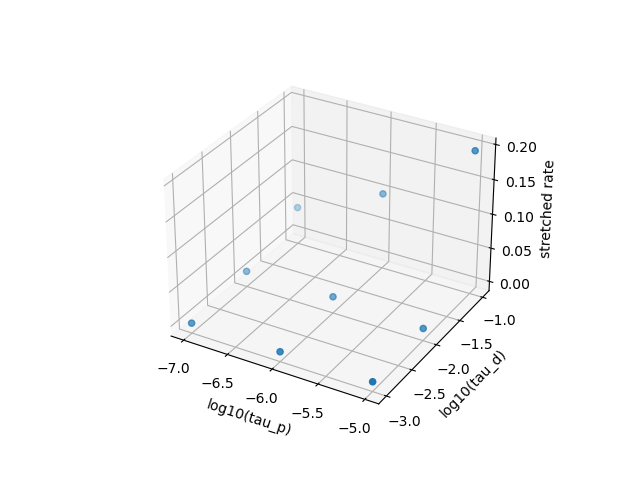

<IPython.core.display.Javascript object>


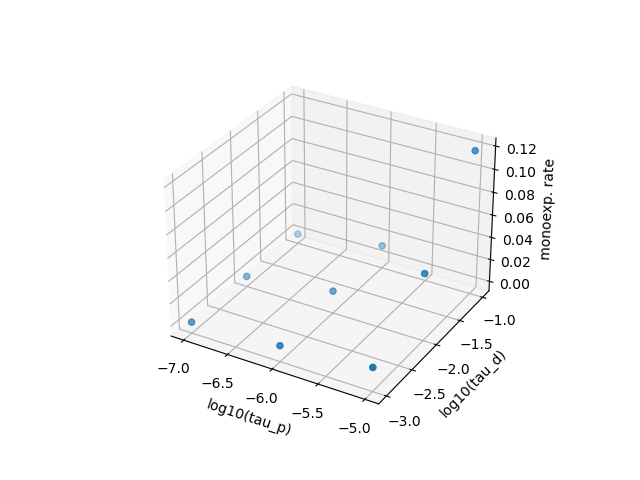

In [1042]:
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x, y = np.meshgrid(tau_p, tau_d)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.scatter(np.log10(x), np.log10(y), stretched)

# Labels
ax.set_xlabel('log10(tau_p)')
ax.set_ylabel('log10(tau_d)')
ax.set_zlabel('stretched rate')

# plt.title("3D Surface Plot")
plt.show()


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.scatter(np.log10(x), np.log10(y), mono)

# Labels
ax.set_xlabel('log10(tau_p)')
ax.set_ylabel('log10(tau_d)')
ax.set_zlabel('monoexp. rate')

# plt.title("3D Surface Plot")
plt.show()


In [1189]:
#In the next cells, want to calculate the effective dipolar interactions during the pulse sequence. This requires calculating
#the effective rotation of one pulse + delay (one Floquet period), calculating the average dipolar Hamiltonian during one
#period, calculating the effective rotation axis, and finally finding the secular part of the effective dipolar Hamiltonian
#with respect to the effective rotation axis

In [48]:
#Define basis states and spin operators
upup = np.array([1,0,0,0]).reshape(4,1)
updown = np.array([0,1,0,0]).reshape(4,1)
downup = np.array([0,0,1,0]).reshape(4,1)
downdown = np.array([0,0,0,1]).reshape(4,1)

S_plus = np.array([[0,0,1,0], [0,0,0,1], [0,0,0,0], [0,0,0,0]])
S_minus = np.array([[0,0,0,0], [0,0,0,0], [1,0,0,0], [0,1,0,0]])
I_plus = np.array([[0,1,0,0], [0,0,0,0], [0,0,0,1], [0,0,0,0]])
I_minus = np.array([[0,0,0,0], [1,0,0,0], [0,0,0,0], [0,0,1,0]])

S_x = (1/2)*(S_plus + S_minus)
S_y = (1/2j)*(S_plus - S_minus)
I_x = (1/2)*(I_plus + I_minus)
I_y = (1/2j)*(I_plus - I_minus)

S_z = (1/2)*np.diag([1,1,-1,-1])
I_z = (1/2)*np.diag([1,-1,1,-1])

Id = np.diag([1,1,1,1])

# I = np.array([I_x, I_y, I_z])
# S = np.array([S_x, S_y, S_z])

In [18]:
#Define experiment parameters and Hamiltonians
w_rabi = 1/(4*40e-6)
offset = 0
pulselength = 40e-6
delay = 40e-6
dt = 100e-9
time = np.linspace(0, pulselength+delay, int((pulselength+delay)/dt))

H_dd = -(I_x @ S_x) - (I_y @ S_y) + 2*(I_z @ S_z)

H_pulse = 2*np.pi*w_rabi*(I_x + S_x) + 2*np.pi*offset*(I_z + S_z)
H_delay = 2*np.pi*offset*(I_z + S_z)

In [19]:
#Calculate the effective rotation axis
# U_final = expm(-1j*H_pulse*pulselength)
U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength)
R_eff = 1j*logm(U_final)

norm = abs(np.trace(R_eff @ R_eff.conj().T))

mu_x = (np.trace(R_eff @ I_x.conj().T)/norm).real
mu_y = (np.trace(R_eff @ I_y.conj().T)/norm).real
mu_z = (np.trace(R_eff @ I_z.conj().T)/norm).real

r = np.sqrt(mu_x**2 + mu_y**2 + mu_z**2)
theta_eff = np.arccos(mu_z/r)
print('theta =', theta_eff*180/np.pi, 'degrees')

theta = 90.0 degrees


Detected resonance conditions (omega_d ≈ n * omega_eff):
Offset: 0.0 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12500.00 Hz
Offset: 16.0 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12500.16 Hz
Offset: 32.1 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12500.62 Hz
Offset: 48.1 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12501.40 Hz
Offset: 64.1 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12502.49 Hz
Offset: 80.2 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12503.89 Hz
Offset: 96.2 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12505.60 Hz
Offset: 112.2 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12507.63 Hz
Offset: 128.3 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12509.96 Hz
Offset: 144.3 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12512.60 Hz
Offset: 160.3 Hz | Harmonic n: 4 | omega_d: 12500.00 Hz | n * omega_eff: 12515.56 Hz
Offset: 176.4 Hz

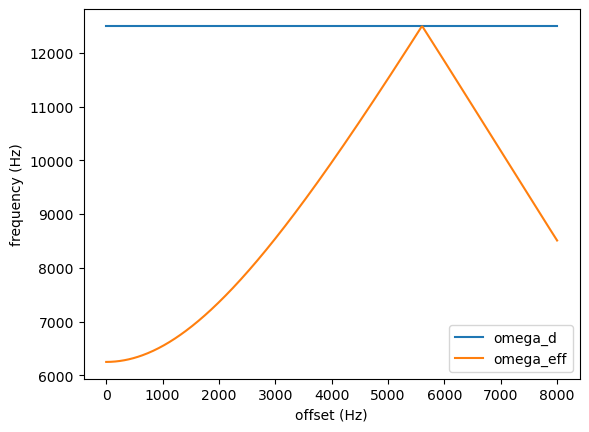

In [96]:
def calculate_resonance_conditions(w_rabi, pulselength, delay, offset):

    dt = 100e-9
    time = np.linspace(0, pulselength+delay, int((pulselength+delay)/dt))

    H_dd = -(I_x @ S_x) - (I_y @ S_y) + 2*(I_z @ S_z)

    H_pulse = 2*np.pi*w_rabi*(I_x + S_x) + 2*np.pi*offset*(I_z + S_z)
    H_delay = 2*np.pi*offset*(I_z + S_z)

    #Calculate the effective frequency
    U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength)
    H_eff = (1j / (pulselength + delay)) * logm(U_final)

    evals, evecs = eig(H_eff)
    omega_eff = max(evals).real / (2*np.pi)
    
    omega_d = 1 / (pulselength + delay)
    
    return omega_d, omega_eff

N = 500
w_rabi = 1/(4*40e-6)
pulselength = 40e-6
delay = 40e-6
offset = np.linspace(0, 8e3, N)

omega_d = np.zeros(N)
omega_eff = np.zeros(N)

for i in range(N):
    omega_d[i], omega_eff[i] = calculate_resonance_conditions(w_rabi, pulselength, delay, offset[i])

    
    
resonances = []

tolerance = 0.01  # how close to integer multiple

for i in range(N):
    if omega_eff[i] == 0:
        continue
    ratio = omega_d[i] / omega_eff[i]
    n = round(ratio)
    if abs(ratio - n) < tolerance:
        resonances.append((offset[i], n, omega_d[i], omega_eff[i]))

# Print results
print("Detected resonance conditions (omega_d ≈ n * omega_eff):")
for off, n, od, oe in resonances:
    print(f"Offset: {off:.1f} Hz | Harmonic n: {n} | omega_d: {od:.2f} Hz | n * omega_eff: {n*oe:.2f} Hz")
    
    
fig = plt.figure()
plt.plot(offset, omega_d, label = 'omega_d')
plt.plot(offset, 2*omega_eff, label = 'omega_eff')
plt.xlabel("offset (Hz)")
plt.ylabel("frequency (Hz)")
plt.legend()
plt.show()

In [161]:
def calculate_resonance_conditions(w_rabi, pulselength, delay, offset):

    dt = 100e-9
    time = np.linspace(0, pulselength+delay, int((pulselength+delay)/dt))

    H_dd = -(I_x @ S_x) - (I_y @ S_y) + 2*(I_z @ S_z)

    H_pulse = 2*np.pi*w_rabi*(I_x + S_x) + 2*np.pi*offset*(I_z + S_z)
    H_delay = 2*np.pi*offset*(I_z + S_z)

    #Calculate the effective frequency
    U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength)
    H_eff = (1j / (pulselength + delay)) * logm(U_final)

    evals, evecs = eig(H_eff)
    omega_eff = max(evals).real / (2*np.pi)
    
    omega_d = 1 / (pulselength + delay)
    
    return omega_d, omega_eff

calculate_resonance_conditions(1/(4*56e-6), 56e-6, 36e-6, 0)

(10869.565217391304, 2717.3913043478296)

In [123]:
#Calculate alignment between initial magnetization vector and quantization axis

def calculate_quant_axis(w_rabi, pulselength, delay, offset):
    H_pulse = 2*np.pi*w_rabi*(I_x + S_x) + 2*np.pi*offset*(I_z + S_z)
    H_delay = 2*np.pi*offset*(I_z + S_z)

    U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength)
    R_eff = 1j*logm(U_final)

    norm = abs(np.trace(R_eff @ R_eff.conj().T))

    mu_x = (np.trace(R_eff @ I_x.conj().T)/norm).real
    mu_y = (np.trace(R_eff @ I_y.conj().T)/norm).real
    mu_z = (np.trace(R_eff @ I_z.conj().T)/norm).real

    r = np.sqrt(mu_x**2 + mu_y**2 + mu_z**2)
    theta_eff = np.arccos(mu_z/r) * 180/np.pi
    
    return theta_eff


def calculate_initial_angles(w_rabi, offset, phase, tau):

    H_init = (2*np.pi*w_rabi) * (np.cos(np.deg2rad(phase))*(I_x + S_x) + np.sin(np.deg2rad(phase))*(I_y + S_y)) + \
    2*np.pi*offset*(I_z + S_z)
    U_init = expm(-1j*H_init*tau)
    psi_init = U_init @ upup

    rho_full = np.outer(psi_init, psi_init.conj())
    # Partial trace over qubit S (second qubit) to get reduced state of qubit I
    rho_I = np.zeros((2, 2), dtype=complex)
    for i in range(2):
        for j in range(2):
            rho_I[i, j] = np.trace(rho_full[i::2, j::2])
    eigvals, eigvecs = np.linalg.eigh(rho_I)
    psi_I = eigvecs[:, np.argmax(eigvals)]
    psi_I = psi_I / np.linalg.norm(psi_I)

    # Components of single-qubit state
    a = psi_I[0]  # amplitude of |0⟩ (spin-up)
    b = psi_I[1]  # amplitude of |1⟩ (spin-down)

    # Polar angle θ
    theta = 2 * np.arccos(np.abs(a))

    # Azimuthal angle φ
    phi = np.angle(b) - np.angle(a)
    phi = np.mod(phi, 2 * np.pi)  # ensure in [0, 2π)

    # Optionally in degrees
    theta_deg = np.degrees(theta)
    phi_deg = np.degrees(phi)

#     print(f"phi (rad): {phi}, phi (deg): {np.degrees(phi)}")
        
    return theta_deg, phi_deg


N = 51
M = 361
L = 51
offset_vals = np.linspace(0,5e3,N)
phase_vals = np.linspace(0,360,M)
tau_vals = np.linspace(0,50e-6,L)
results = []

for i in range(N):
    offset = offset_vals[i]
    theta_quant = calculate_quant_axis(1/(4*40e-6), 40e-6, 40e-6, offset)
    
    best_error = np.inf
    best_match = None
    
    for p in range(M):
        for q in range(L):
            phase = phase_vals[p]
            tau =  tau_vals[q]
            theta, phi = calculate_initial_angles(1/(4*40e-6), offset, phase, tau)
            
            # Compute error: how far is this from the target (theta_quant, phi = 0)
            theta_error = np.abs(theta - theta_quant)
            phi_error = np.abs(phi)  # ensure phi in [0, 2π)
#             phi_error = min(phi_error, 2*np.pi - phi_error)  # shortest angular distance

            total_error = theta_error + phi_error
           
            if total_error < best_error:
                best_error = total_error
                best_match = {
                    'offset': offset,
                    'theta_quant': theta_quant,
                    'theta': theta,
                    'phi': phi,
                    'phase': phase,
                    'tau': tau
                }

    if best_match:
        results.append(best_match)

# Example: print the results
for r in results:
    print(f"Offset: {r['offset']:.1f} Hz | θ_quant: {r['theta_quant']:.2f}° | "
          f"θ: {r['theta']:.2f}° | φ: {r['phi']:.2f}° | "
          f"Phase: {r['phase']:.1f}° | Tau: {r['tau']*1e6:.2f} µs")
            


Offset: 0.0 Hz | θ_quant: 90.00° | θ: 90.00° | φ: 0.00° | Phase: 90.0° | Tau: 40.00 µs
Offset: 100.0 Hz | θ_quant: 88.36° | θ: 87.75° | φ: 0.88° | Phase: 90.0° | Tau: 39.00 µs
Offset: 200.0 Hz | θ_quant: 86.73° | θ: 87.74° | φ: 0.76° | Phase: 89.0° | Tau: 39.00 µs
Offset: 300.0 Hz | θ_quant: 85.11° | θ: 85.48° | φ: 0.54° | Phase: 88.0° | Tau: 38.00 µs
Offset: 400.0 Hz | θ_quant: 83.49° | θ: 83.21° | φ: 0.26° | Phase: 87.0° | Tau: 37.00 µs
Offset: 500.0 Hz | θ_quant: 81.89° | θ: 83.19° | φ: 0.07° | Phase: 86.0° | Tau: 37.00 µs
Offset: 600.0 Hz | θ_quant: 80.30° | θ: 80.92° | φ: 0.70° | Phase: 86.0° | Tau: 36.00 µs
Offset: 700.0 Hz | θ_quant: 78.74° | θ: 78.65° | φ: 0.26° | Phase: 85.0° | Tau: 35.00 µs
Offset: 800.0 Hz | θ_quant: 77.20° | θ: 78.62° | φ: 0.02° | Phase: 84.0° | Tau: 35.00 µs
Offset: 900.0 Hz | θ_quant: 75.68° | θ: 76.36° | φ: 0.50° | Phase: 84.0° | Tau: 34.00 µs
Offset: 1000.0 Hz | θ_quant: 74.19° | θ: 74.09° | φ: 0.94° | Phase: 84.0° | Tau: 33.00 µs
Offset: 1100.0 Hz | θ_

In [160]:
theta_quant = calculate_quant_axis(1/(4*40e-6), 40e-6, 40e-6, 2435)
theta, phi = calculate_initial_angles(1/(4*40e-6), 2435, 75, 10e-6)

print('theta_quant =', theta_quant, 'theta =', theta, 'phi =', phi)

theta_quant = 56.591123809248536 theta = 22.47771851508018 phi = 349.4401394001717


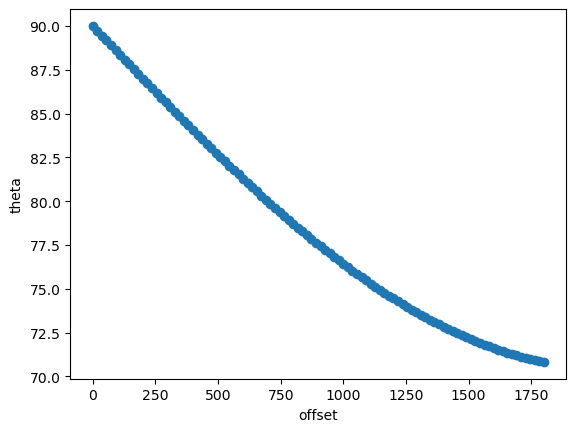

In [33]:
#Define basis states and spin operators
I_x = (1/2)*np.array([[0,1], [1,0]])
I_y = (1/2)*np.array([[0,-1j], [1j,0]])
I_z = (1/2)*np.array([[1,0], [0,-1]])

def calculate_quant_axis(w_rabi, pulselength, delay, offset):
    H_pulse = 2*np.pi*w_rabi*(I_x) + 2*np.pi*offset*(I_z)
    H_delay = 2*np.pi*offset*(I_z)

    U_final = expm(-1j*H_delay*delay/2) @ expm(-1j*H_pulse*pulselength) @ expm(-1j*H_delay*delay/2) 
#     U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength) 
    R_eff = 1j*logm(U_final)

    norm = abs(np.trace(R_eff @ R_eff.conj().T))
    
    mu_x = (np.trace(R_eff @ I_x.conj().T)/norm).real
    mu_y = (np.trace(R_eff @ I_y.conj().T)/norm).real
    mu_z = (np.trace(R_eff @ I_z.conj().T)/norm).real
        
    r = np.sqrt(mu_x**2 + mu_y**2 + mu_z**2)
    theta_eff = np.arccos(mu_z/r) * 180/np.pi
#     phi_eff = np.arctan2(mu_y/r, mu_x/r) * 180/np.pi
    
    return theta_eff, mu_z

N = 100
rabi = 1/(4*56e-6)
pulselength = 0.92*(2*56e-6)
delay = 100e-6
offset = np.linspace(0,1.8e3,N)

theta = np.zeros(N)
mu_z = np.zeros(N)
for i in range(N):
    theta[i], mu_z[i] = calculate_quant_axis(rabi, pulselength, delay, offset[i])

fig = plt.figure()
plt.scatter(offset, theta)
plt.xlabel("offset")
plt.ylabel("theta")
# plt.grid('True')
plt.show()

# fig = plt.figure()
# plt.scatter(offset, mu_z)
# plt.xlabel("offset")
# plt.ylabel("mu_z")
# plt.show()

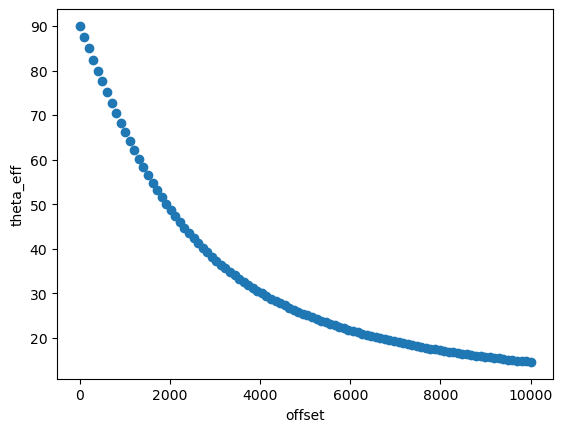

In [61]:
def cot(x):
    return 1 / np.tan(x)

def csc(x):
    return 1 / np.sin(x)

def arccot(x):
    return np.arctan(1 / x)

N = 100
rabi = 1/(4*56e-6)
pulselength = 0.92*(2*56e-6)
delay = 100e-6
offset = np.linspace(0,10e3,N)

theta_eff = np.zeros(N)
for i in range(N):
    if offset[i] == 0:
        theta_eff[i] = np.pi/2
    else:
        psi = pulselength * np.sqrt(rabi**2 + offset[i]**2)
        gamma = delay * offset[i]
        eta = np.arctan2(rabi, offset[i])

        theta_eff[i] = arccot(np.cos(gamma/2) * cot(eta) + cot(psi/2) * csc(eta) * np.sin(gamma/2))
        
fig = plt.figure()
plt.scatter(offset, np.degrees(theta_eff))
plt.xlabel("offset")
plt.ylabel("theta_eff")
# plt.grid('True')
plt.show()

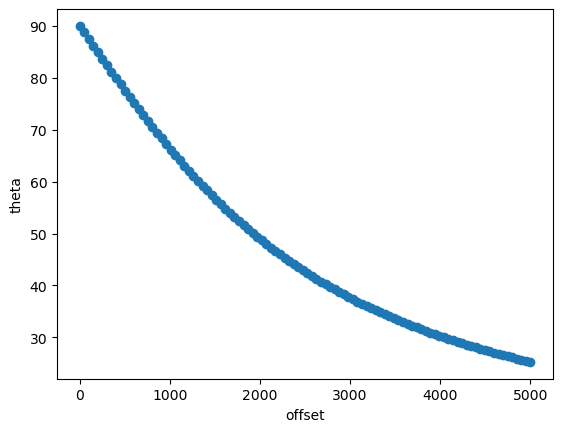

In [189]:
from scipy.spatial.transform import Rotation as R

def axis_angle_to_quaternion(axis, angle_rad):
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)  # Ensure it's a unit vector
    return R.from_rotvec(angle_rad * axis).as_quat()  # [x, y, z, w] format

def quaternion_to_axis_angle(quat):
    r = R.from_quat(quat)
    angle = r.magnitude()
    axis = r.as_rotvec()
    if angle == 0:
        return np.array([0, 0, 1]), 0.0
    return axis / np.linalg.norm(axis), angle

def combine_rotations(n, theta1, theta2):
    # Convert degrees to radians
#     theta1 = np.deg2rad(theta1_deg)
#     theta2 = np.deg2rad(theta2_deg)

    # First rotation: about arbitrary axis n
    q1 = axis_angle_to_quaternion(n, theta1)  # returns [x, y, z, w]

    # Second rotation: about z-axis
    z_axis = [0, 0, 1]
    q2 = axis_angle_to_quaternion(z_axis, theta2)  # [x, y, z, w]

    # Convert to scipy's Rotation format which uses [x, y, z, w]
    r1 = R.from_quat(q1)
    r2 = R.from_quat(q2)

    # Combined rotation: r = r2 * r1 (r1 followed by r2)
    r_combined = r2 * r1
    quat_combined = r_combined.as_quat()  # [x, y, z, w]

    # Extract axis and angle
    axis, angle = quaternion_to_axis_angle(quat_combined)
    angle_deg = np.rad2deg(angle)

    return axis, angle_deg

N = 100
rabi = 1/(4*56e-6)
pulselength = 0.92*(2*56e-6)
delay = 100e-6
offset = np.linspace(0,5e3,N)

axis = np.zeros((N,3))
angle = np.zeros(N)
for i in range(N):
    w_eff = np.sqrt(rabi**2 + (offset[i])**2) 
    nx = rabi / w_eff
    ny = 0 
    nz = offset[i] / w_eff
    n = np.array([nx, ny, nz])
    theta1 = w_eff * pulselength
    theta2 = offset[i] * delay
    
    axis[i,:], angle[i] = combine_rotations(n, theta1, theta2)

theta_quant = np.arccos(axis[:,2]) * 180/np.pi
fig = plt.figure()
plt.scatter(offset, theta_quant)
plt.xlabel("offset")
plt.ylabel("theta")
plt.show()

In [86]:
# #This cell will calculate the effective dipolar coupling scaling factor in the interaction picture of the entire RF pulse
# #sequence. The resulting effective Hamiltonian is not periodic and includes a term given by w_eff*I_mu.


# ###Calculate effective H_dd as a function of time in the interaction picture of the entire pulse sequence
# H_eff_dd = np.zeros((len(time), 4, 4), dtype='complex')

# for t in range(len(time)):
#     if t < int(pulselength/dt):
#         U = expm(-1j*H_pulse*time[t])
#         H_eff_dd[t,:,:] = U.conj().T @ H_dd @ U
#     else:
#         U = expm(-1j*H_delay*(time[t]-pulselength)) @ expm(-1j*H_pulse*pulselength)
#         H_eff_dd[t,:,:] = U.conj().T @ H_dd @ U 
        
        

# ###Calculate average effective H_dd in the interaction picture of the entire pulse sequence by integrating over time
# H_eff_dd_avg = np.zeros((4, 4), dtype='complex')

# for m in range(4):
#     for n in range(4):
#         H_eff_dd_avg[m,n] = simps(H_eff_dd[:,m,n], time)
    
# H_eff_dd_avg = (1/(pulselength+delay))*H_eff_dd_avg



# ###Define I_mu and find the component of H_tilde_dd_avg commutes with I_mu
# I_mu = mu_x*(I_x+S_x) + mu_y*(I_y+S_y) + mu_z*(I_z+S_z)
# # I_mu = I_z+S_z

# # I_mu*X - X*I_mu = 0 → (Id⊗I_mu - I_muᵗ⊗Id) vec(X) = 0 (wrong)
# K = np.kron(I_mu, Id) - np.kron(Id, I_mu.T)
# #nullspace of K represents basis for space of solutions X which commute with I_mu
# null_basis = null_space(K)

# #Project H_eff_dd_avg onto null_basis
# H_vec = H_eff_dd_avg.flatten()
# H_proj = np.zeros_like(H_vec)

# for i in range(null_basis.shape[1]):
#     v = null_basis[:,i]
#     H_coeff = (H_vec @ v)/(v @ v)
#     H_proj = H_proj + H_coeff*v
    
# H_avg_secular = H_proj.reshape(4,4)

# scaling_factor = np.sqrt(2/3*np.trace(H_avg_secular @ H_avg_secular.conj().T))

# print('scaling factor =', scaling_factor)

In [45]:
#This cell will calculate the effective dipolar coupling scaling factor in the interaction picture of just the periodic part
#of the RF pulse sequence. The resulting effective Hamiltonian is periodic and only includes the effective dipolar term.


###Calculate effective H_dd as a function of time in the interaction picture of just the periodic part of the pulse sequence
H_eff_dd = np.zeros((len(time), 4, 4), dtype='complex')

for t in range(len(time)):
    if t < int(pulselength/dt):
        U_rf = expm(-1j*H_pulse*time[t])
        U_eff = expm(1j*R_eff*time[t])
        P = U_rf @ U_eff
        H_eff_dd[t,:,:] = P.conj().T @ H_dd @ P
    else:
        U_rf = expm(-1j*H_delay*(time[t]-pulselength)) @ expm(-1j*H_pulse*pulselength)
        U_eff = expm(1j*R_eff*time[t])
        P = U_rf @ U_eff
        H_eff_dd[t,:,:] = P.conj().T @ H_dd @ P

        
        
###Calculate average effective H_dd in the interaction picture of just the periodic part of the pulse sequence by integrating 
#over time
H_eff_dd_avg = np.zeros((4, 4), dtype='complex')

for m in range(4):
    for n in range(4):
        H_eff_dd_avg[m,n] = simps(H_eff_dd[:,m,n], time)
    
H_eff_dd_avg = (1/(pulselength+delay))*H_eff_dd_avg


###Define I_mu and find the component of H_tilde_dd_avg commutes with I_mu
I_mu = mu_x*(I_x+S_x) + mu_y*(I_y+S_y) + mu_z*(I_z+S_z)

# I_mu*X - X*I_mu = 0 → (I_mu⊗Id - Id⊗I_Mu.T)vec(X) = 0 
K = np.kron(I_mu, Id) - np.kron(Id, I_mu.T)
#nullspace of K represents basis for space of solutions X which commute with I_mu
null_basis = null_space(K)


#Project H_eff_dd_avg onto null_basis
H_vec = H_eff_dd_avg.flatten()
H_proj = np.zeros_like(H_vec)

for i in range(null_basis.shape[1]):
    v = null_basis[:,i]
    H_coeff = (H_vec @ v.conj())/(v @ v.conj())
    H_proj = H_proj + H_coeff*v
    
H_avg_secular = H_proj.reshape(4,4)

scaling_factor = (np.sqrt(2/3*np.trace(H_avg_secular @ H_avg_secular.conj().T))).real
print('scaling factor =', scaling_factor)

scaling factor = 0.5


In [46]:
#Now want to do a similar calculation but for the electron-nuclear coupling under the interaction of the pulse sequence
#Make general definition where Hamiltonian is input into the function as a parameter and the effective average secular 
#Hamiltonian and scaling factor are calculated

In [43]:
def calculate_scaling_dd(w_rabi, offset, pulselength, delay, dt):

    #Define basis states and spin operators
    upup = np.array([1,0,0,0]).reshape(4,1)
    updown = np.array([0,1,0,0]).reshape(4,1)
    downup = np.array([0,0,1,0]).reshape(4,1)
    downdown = np.array([0,0,0,1]).reshape(4,1)

    S_plus = np.array([[0,0,1,0], [0,0,0,1], [0,0,0,0], [0,0,0,0]])
    S_minus = np.array([[0,0,0,0], [0,0,0,0], [1,0,0,0], [0,1,0,0]])
    I_plus = np.array([[0,1,0,0], [0,0,0,0], [0,0,0,1], [0,0,0,0]])
    I_minus = np.array([[0,0,0,0], [1,0,0,0], [0,0,0,0], [0,0,1,0]])

    S_x = (1/2)*(S_plus + S_minus)
    S_y = (1/2j)*(S_plus - S_minus)
    I_x = (1/2)*(I_plus + I_minus)
    I_y = (1/2j)*(I_plus - I_minus)

    S_z = (1/2)*np.diag([1,1,-1,-1])
    I_z = (1/2)*np.diag([1,-1,1,-1])

    Id = np.diag([1,1,1,1])


    #Define experiment parameters and Hamiltonians
    time = np.linspace(0, pulselength+delay, int((pulselength+delay)/dt))

    H = -(I_x @ S_x) - (I_y @ S_y) + 2*(I_z @ S_z)
#     H = I_z + S_z

    H_pulse = 2*np.pi*w_rabi*(I_x + S_x) + 2*np.pi*offset*(I_z + S_z)
    H_delay = 2*np.pi*offset*(I_z + S_z)


    #Calculate the effective rotation axis
    U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength)
    R_eff = 1j*logm(U_final)

    norm = abs(np.trace(R_eff @ R_eff.conj().T))

    mu_x = (np.trace(R_eff @ I_x.conj().T)/norm).real
    mu_y = (np.trace(R_eff @ I_y.conj().T)/norm).real
    mu_z = (np.trace(R_eff @ I_z.conj().T)/norm).real

    r = np.sqrt(mu_x**2 + mu_y**2 + mu_z**2)
    theta_eff = (np.arccos(mu_z/r))*(180/np.pi)


    ###Calculate effective H_dd as a function of time in the interaction picture of just the periodic part of the pulse sequence
    H_eff = np.zeros((len(time), 4, 4), dtype='complex')

    for t in range(len(time)):
        if t < int(pulselength/dt):
            U_rf = expm(-1j*H_pulse*time[t])
            U_eff = expm(1j*R_eff*time[t])
            P = U_rf @ U_eff
            H_eff[t,:,:] = P.conj().T @ H @ P
        else:
            U_rf = expm(-1j*H_delay*(time[t]-pulselength)) @ expm(-1j*H_pulse*pulselength)
            U_eff = expm(1j*R_eff*time[t])
            P = U_rf @ U_eff
            H_eff[t,:,:] = P.conj().T @ H @ P



    ###Calculate average effective H_dd in the interaction picture of just the periodic part of the pulse sequence by 
    #integrating over time
    H_eff_avg = np.zeros((4, 4), dtype='complex')

    for m in range(4):
        for n in range(4):
            H_eff_avg[m,n] = simps(H_eff[:,m,n], time)

    H_eff_avg = (1/(pulselength+delay))*H_eff_avg



    ###Define I_mu and find the component of H_tilde_dd_avg commutes with I_mu
    I_mu = mu_x*(I_x+S_x) + mu_y*(I_y+S_y) + mu_z*(I_z+S_z)

    # I_mu*X - X*I_mu = 0 → (I_mu⊗Id - Id⊗I_Mu.T)vec(X) = 0 
    K = np.kron(I_mu, Id) - np.kron(Id, I_mu.T)
    #nullspace of K represents basis for space of solutions X which commute with I_mu
    null_basis = null_space(K)

    #Project H_eff_dd_avg onto null_basis
    H_vec = H_eff_avg.flatten()
    H_proj = np.zeros_like(H_vec)

    for i in range(null_basis.shape[1]):
        v = null_basis[:,i]
        H_coeff = (H_vec @ v.conj())/(v @ v.conj())
        H_proj = H_proj + H_coeff*v

    H_avg_secular = H_proj.reshape(4,4)

    scaling_factor = (np.sqrt(2/3*np.trace(H_avg_secular @ H_avg_secular.conj().T))).real

    return theta_eff, scaling_factor

In [44]:
def calculate_scaling_hf(w_rabi, offset, pulselength, delay, dt):

    #Define basis states and spin operators
    upup = np.array([1,0,0,0]).reshape(4,1)
    updown = np.array([0,1,0,0]).reshape(4,1)
    downup = np.array([0,0,1,0]).reshape(4,1)
    downdown = np.array([0,0,0,1]).reshape(4,1)

    S_plus = np.array([[0,0,1,0], [0,0,0,1], [0,0,0,0], [0,0,0,0]])
    S_minus = np.array([[0,0,0,0], [0,0,0,0], [1,0,0,0], [0,1,0,0]])
    I_plus = np.array([[0,1,0,0], [0,0,0,0], [0,0,0,1], [0,0,0,0]])
    I_minus = np.array([[0,0,0,0], [1,0,0,0], [0,0,0,0], [0,0,1,0]])

    S_x = (1/2)*(S_plus + S_minus)
    S_y = (1/2j)*(S_plus - S_minus)
    I_x = (1/2)*(I_plus + I_minus)
    I_y = (1/2j)*(I_plus - I_minus)

    S_z = (1/2)*np.diag([1,1,-1,-1])
    I_z = (1/2)*np.diag([1,-1,1,-1])

    Id = np.diag([1,1,1,1])


    #Define experiment parameters and Hamiltonians
    time = np.linspace(0, pulselength+delay, int((pulselength+delay)/dt))

#     H_dd = -(I_x @ S_x) - (I_y @ S_y) + 2*(I_z @ S_z)
    H = I_z + S_z

    H_pulse = 2*np.pi*w_rabi*(I_x + S_x) + 2*np.pi*offset*(I_z + S_z)
    H_delay = 2*np.pi*offset*(I_z + S_z)


    #Calculate the effective rotation axis
    U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength)
    R_eff = 1j*logm(U_final)

    norm = abs(np.trace(R_eff @ R_eff.conj().T))

    mu_x = (np.trace(R_eff @ I_x.conj().T)/norm).real
    mu_y = (np.trace(R_eff @ I_y.conj().T)/norm).real
    mu_z = (np.trace(R_eff @ I_z.conj().T)/norm).real

    r = np.sqrt(mu_x**2 + mu_y**2 + mu_z**2)
    theta_eff = (np.arccos(mu_z/r))*(180/np.pi)


    ###Calculate effective H_dd as a function of time in the interaction picture of just the periodic part of the pulse sequence
    H_eff = np.zeros((len(time), 4, 4), dtype='complex')

    for t in range(len(time)):
        if t < int(pulselength/dt):
            U_rf = expm(-1j*H_pulse*time[t])
            U_eff = expm(1j*R_eff*time[t])
            P = U_rf @ U_eff
            H_eff[t,:,:] = P.conj().T @ H @ P
        else:
            U_rf = expm(-1j*H_delay*(time[t]-pulselength)) @ expm(-1j*H_pulse*pulselength)
            U_eff = expm(1j*R_eff*time[t])
            P = U_rf @ U_eff
            H_eff[t,:,:] = P.conj().T @ H @ P



    ###Calculate average effective H_dd in the interaction picture of just the periodic part of the pulse sequence by 
    #integrating over time
    H_eff_avg = np.zeros((4, 4), dtype='complex')

    for m in range(4):
        for n in range(4):
            H_eff_avg[m,n] = simps(H_eff[:,m,n], time)

    H_eff_avg = (1/(pulselength+delay))*H_eff_avg



    ###Define I_mu and find the component of H_tilde_dd_avg commutes with I_mu
    I_mu = mu_x*(I_x+S_x) + mu_y*(I_y+S_y) + mu_z*(I_z+S_z)

    # I_mu*X - X*I_mu = 0 → (I_mu⊗Id - Id⊗I_Mu.T)vec(X) = 0 
    K = np.kron(I_mu, Id) - np.kron(Id, I_mu.T)
    #nullspace of K represents basis for space of solutions X which commute with I_mu
    null_basis = null_space(K)

    #Project H_eff_dd_avg onto null_basis
    H_vec = H_eff_avg.flatten()
    H_proj = np.zeros_like(H_vec)

    for i in range(null_basis.shape[1]):
        v = null_basis[:,i]
        H_coeff = (H_vec @ v.conj())/(v @ v.conj())
        H_proj = H_proj + H_coeff*v

    H_avg_secular = H_proj.reshape(4,4)
    
    H_avg_nonsecular = H_eff_avg - H_avg_secular

    scaling_factor = (np.sqrt(1/2*np.trace(H_avg_nonsecular @ H_avg_nonsecular.conj().T))).real

    return theta_eff, scaling_factor

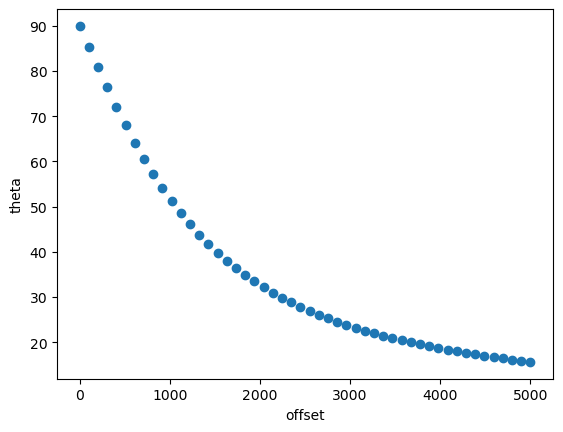

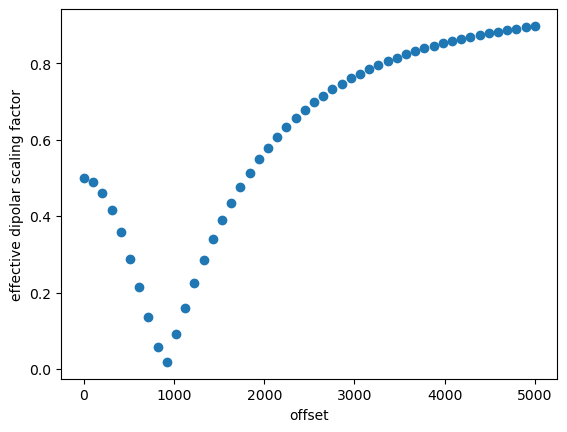

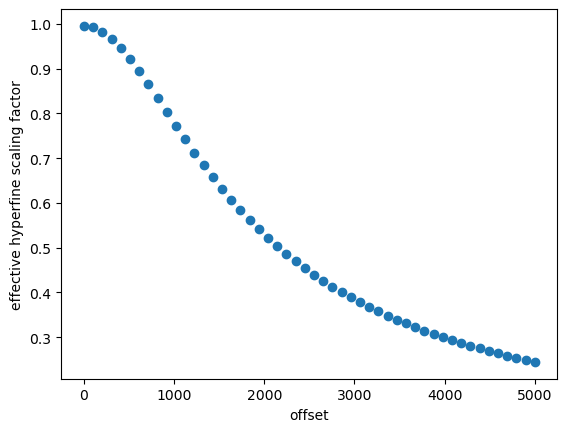

In [46]:
N = 50
theta = np.zeros(N)
scaling_factor_dd = np.zeros(N)
scaling_factor_hf = np.zeros(N)
offset = np.linspace(0,5e3,N)

for i in range(N):
    theta[i], scaling_factor_dd[i] = calculate_scaling_dd(1/(4*40e-6), offset[i], 10e-6, 40e-6, 100e-9)
    theta_hf, scaling_factor_hf[i] = calculate_scaling_hf(1/(4*40e-6), offset[i], 10e-6, 40e-6, 100e-9)

fig = plt.figure()
plt.scatter(offset, theta)
plt.xlabel("offset")
plt.ylabel("theta")
plt.show()
    
fig = plt.figure()
plt.scatter(offset, scaling_factor_dd)
plt.xlabel("offset")
plt.ylabel("effective dipolar scaling factor")
plt.show()

fig = plt.figure()
plt.scatter(offset, scaling_factor_hf)
plt.xlabel("offset")
plt.ylabel("effective hyperfine scaling factor")
plt.show()

# fig = plt.figure()
# plt.scatter(offset, scaling_factor_dd*scaling_factor_hf)
# plt.xlabel("offset")
# plt.ylabel("dipolar times hyperfine scaling factor")
# plt.show()

In [91]:
#Now will simulate a few different lattice configurations. For each lattice configuration, multiply by effective scaling factor
#for homonuclear dipolar and hyperfine hamiltonians based on pulse sequence parameters

import time
iterations = 10 #Number of lattice configurations
size = 12 

w_rabi = 1/(4*40e-6)
pulselength = 40e-6
delay = 43e-6
dt = 100e-9 
N = 25 #Number of offset points
offset = np.linspace(0,5e3,N)

T = np.linspace(0,300,100) #Time for each run
P_avg = np.zeros((N, len(T)))
for k in range(N):
    theta_dd, dd_scaling_factor = calculate_scaling_dd(w_rabi, offset[k], pulselength, delay, dt)
    theta_hf, hf_scaling_factor = calculate_scaling_hf(w_rabi, offset[k], pulselength, delay, dt)

    P = np.zeros((iterations, len(T)))
    start_time = time.time()
    for i in range(iterations):
        carbon_pts, e_pts = place_specials(size)
        N_bulk, M = calculate_M(carbon_pts, e_pts, 3e-6*hf_scaling_factor**2, 3e-2*dd_scaling_factor**2)
        alpha_0 = (1/N_bulk)*np.ones(N_bulk)

        alpha = solve_ode(N_bulk, T, alpha_0, M)
        P[i,:] = np.sum(alpha, axis=0)
        
    P_avg[k,:] = (np.sum(P, axis=0))/iterations
    
    end_time = time.time()
    print(end_time-start_time)

17.52543616294861
17.441113233566284
17.414262294769287
17.359591007232666
17.463834047317505
17.8891658782959
17.666134357452393
17.843804597854614
17.679596662521362
17.885718822479248
17.739022254943848
17.6643807888031
17.573118925094604
17.525328636169434
17.84377646446228
17.60284185409546
17.628582000732422
17.59272837638855
17.59285616874695
17.76992177963257
17.679885387420654
17.770071029663086
18.45108413696289
17.9717276096344
18.345447063446045


[0.00240262 0.00181979 0.00163294 0.00131869 0.0020303  0.00141167
 0.00149971 0.00198042 0.00145885 0.00406049 0.00968599 0.015829
 0.01676656 0.00581525 0.00212049 0.00233512 0.00304684 0.00315352
 0.00610228 0.00459568 0.00540971 0.00306209 0.00423166 0.00743602
 0.00418842]


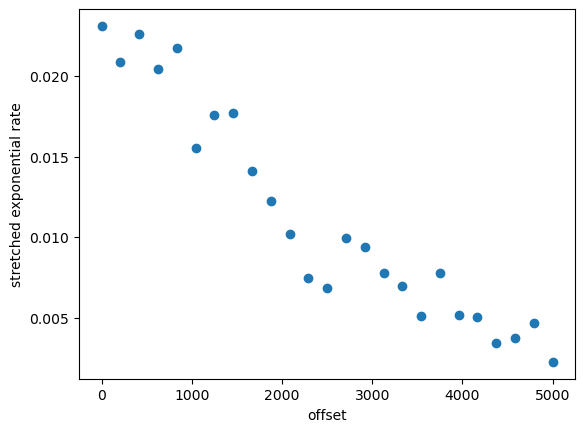

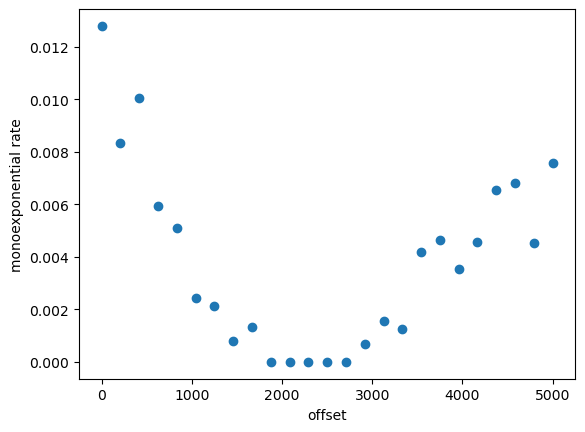

In [92]:
#Fit the data

def product_exp(x, a, b):
    return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

def purely_stretched(x, a):
    return np.exp(-np.sqrt(a*x)) 

def monoexp(x, a):
    return np.exp(-a*x)

stretched_rate = np.zeros(N)
mono_rate = np.zeros(N)
rmse_product = np.zeros(N)
for k in range(N):
    # Fit the data
    popt, pcov = curve_fit(product_exp, T, P_avg[k,:], bounds=([0, 0], [10, 10]))
    
    stretched_rate[k] = popt[0]
    mono_rate[k] = popt[1]
    
    y_fit = product_exp(T, *popt)
    residuals = P_avg[k,:] - y_fit
    rmse_product[k] = np.sqrt(np.mean(residuals**2))
    
    
print(rmse_product)
    
fig = plt.figure()
plt.scatter(offset, stretched_rate)
plt.xlabel("offset")
plt.ylabel("stretched exponential rate")
plt.show()

fig = plt.figure()
plt.scatter(offset, mono_rate)
plt.xlabel("offset")
plt.ylabel("monoexponential rate")
plt.show()

<IPython.core.display.Javascript object>


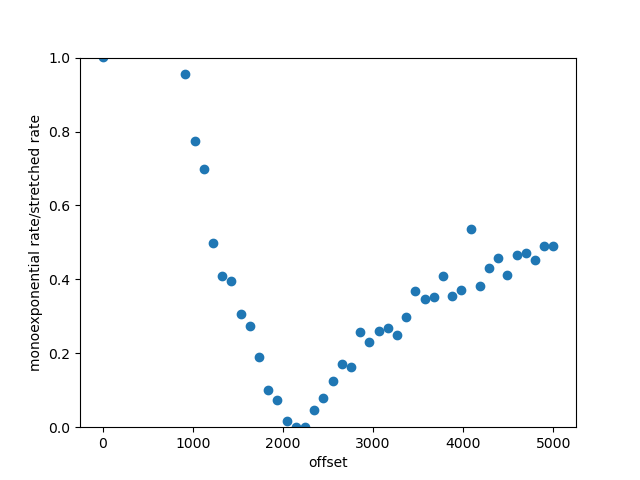

In [2085]:
fig = plt.figure()
plt.scatter(offset, mono_rate/stretched_rate)
plt.xlabel("offset")
plt.ylabel("monoexponential rate/stretched rate")
plt.ylim((0,1))
plt.show()

In [650]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,300,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P

import time
def product_exp(x, a, b):
    return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

N = 10 #Number of tau_p, tau_d values

T = np.linspace(0,300,100)
stretched_rate = np.zeros(N)
monoexp_rate = np.zeros(N)
rmse = np.zeros(N)

iterations = 16 #Monte Carlo runs
tau_p = 1e-6*np.linspace(1.4, 5, N)
tau_d = np.linspace(0.006, 0.012, N)

for i in range(N):
    start_time = time.time()
    inputs = [(tau_p[i], tau_d[i])] * iterations

    pool = Pool()
    results = pool.map(run_simulation, inputs)

    end_time = time.time()
    print(end_time-start_time)

    P_avg = (np.sum(np.array(results), axis=0))/iterations

    # Fit the data
    popt, pcov = curve_fit(product_exp, T, P_avg, bounds=([0, 0], [1, 1]))

    y_fit = product_exp(T, *popt)
    residuals = P_avg - y_fit
    rmse[i] = np.sqrt(np.mean(residuals**2))

    stretched_rate[i] = popt[0]*1e3
    monoexp_rate[i] = popt[1]*1e3
    
print('rmse errors: ', rmse)

6.853943347930908
7.211663246154785
8.071183681488037
8.16110348701477
7.562474966049194
7.228909015655518
7.014827489852905
7.099523544311523
7.232868194580078
7.034834861755371
rmse errors:  [0.00253338 0.00147193 0.00216446 0.00165781 0.00256484 0.00111053
 0.00089882 0.0019504  0.00059386 0.00055854]


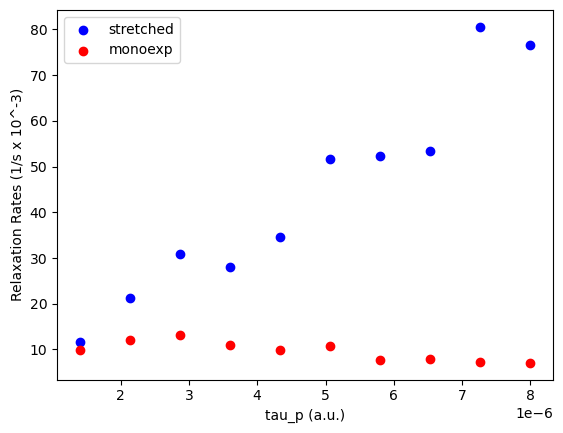

In [649]:
fig = plt.figure()
plt.scatter(tau_p, stretched_rate, color = 'blue', label = 'stretched')
plt.scatter(tau_p, monoexp_rate, color = 'red', label = 'monoexp')
plt.xlabel("tau_p (a.u.)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1.eps", format='eps', dpi=300)

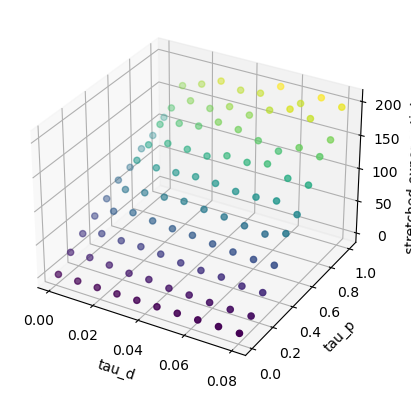

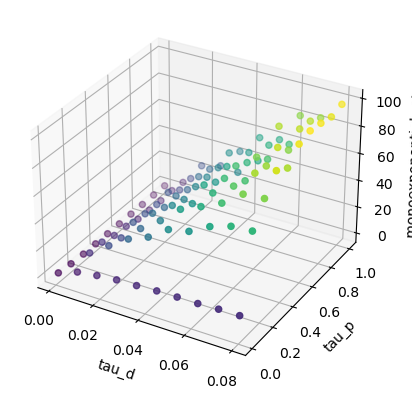

Text(0.5, 0, 'monoexp rate')

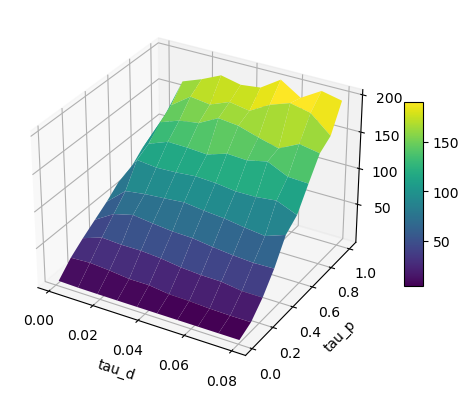

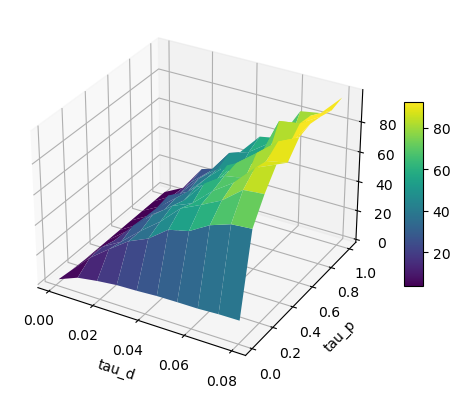

In [6]:
x, y = np.meshgrid(tau_d, tau_p)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, stretched_rate)
c = stretched_rate  # some value to map to color
ax.scatter(x, y, stretched_rate, c=c, cmap='viridis')
ax.set_xlabel('tau_d')
ax.set_ylabel('tau_p')
ax.set_zlabel('stretched exponential rate')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, monoexp_rate)
c = monoexp_rate  # some value to map to color
ax.scatter(x, y, monoexp_rate, c=c, cmap='viridis')
ax.set_xlabel('tau_d')
ax.set_ylabel('tau_p')
ax.set_zlabel('monoexponential rate')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, stretched_rate, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('tau_d')
ax.set_ylabel('tau_p')
ax.set_zlabel('stretched rate')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, monoexp_rate, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_xlabel('tau_d')
ax.set_ylabel('tau_p')
ax.set_zlabel('monoexp rate')

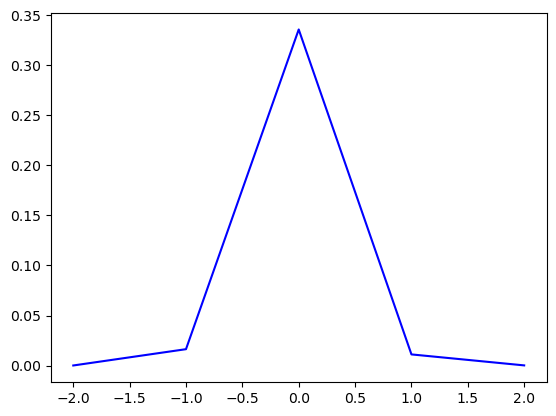

In [35]:
def open_txt(inputstring):
    with open(inputstring, 'r') as f:
        contents = f.read()
    cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
    array = np.array([float(val) for val in cleaned])
    x = array[::2]
    y = array[1::2]
    return x, y

x1, y1 = open_txt('Regime1.txt')
x2, y2 = open_txt('Regime2.txt')
x3, y3 = open_txt('Regime3.txt')

fig = plt.figure()
plt.plot(x2[510:515], y2[510:515], color = 'blue')
plt.xlabel("")
plt.ylabel("")
plt.show()

In [36]:
w_eff1 = 2*np.pi*3205
w_eff2 = 2*np.pi*3878
w_eff3 = 2*np.pi*5008

In [37]:
def calculate_eta(w_eff, tau_c):
    
    def J(w, tau_c):
        return (tau_c)/(1 + (w*tau_c)**2)

    pulselength = 38e-6
    delay = 40e-6
    omega = (2*np.pi) / (pulselength + delay)

    eta = 0
    for k in range(510,515):
        eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)
    
    return eta

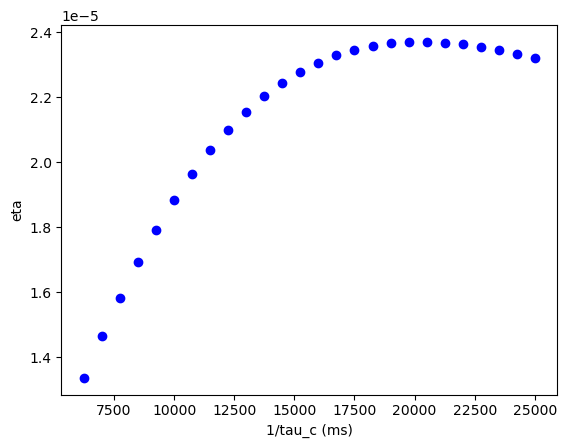

2.3189896120641563e-05 1.3375496426243235e-05


In [40]:
tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, 26))
# tau_c = np.linspace(2.9e-5, 3e-4, 26)
eta = np.zeros(26)
for i in range(26):
    eta[i] = calculate_eta(w_eff1, tau_c[i])
    
fig = plt.figure()
plt.scatter((1/tau_c), eta, color = 'blue')
# plt.gca().invert_xaxis() 
plt.xlabel("1/tau_c (ms)")
plt.ylabel("eta")
plt.show()
print(eta[0], eta[-1])

In [310]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*3205
    w_eff2 = 2*np.pi*3878
    w_eff3 = 2*np.pi*5008
    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 38e-6
        delay = 40e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M


    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_c, tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,300,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p*calculate_eta(w_eff1, tau_c), tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


import time

def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate    
    
    
N = 26 #Number of tau_c values

iterations = 500
tau_p = 0.105*np.ones(N)
tau_d = 1e-2*np.linspace(1.5, 0.7, N)
tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, N))

stretched_rate = np.zeros((N,iterations))
mono_rate = np.zeros((N,iterations))

stretched_avg = np.zeros(N)
mono_avg = np.zeros(N)

for i in range(N):
    print(f"Running tau_c value = {i}")
    start_time = time.time()
    
    inputs = [(tau_c[i], tau_p[i], tau_d[i])] * iterations 
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
    pool.close()
    pool.join()

    T = np.linspace(0,300,100)
    P = np.array(results)
    
    for j in range(iterations):
        stretched_rate[i,j], mono_rate[i,j] = fit_product(P[j,:],T)
        
    P_avg = (np.sum(np.array(results), axis=0))/iterations
    
    stretched_avg[i], mono_avg[i] = fit_product(P_avg,T)
    
    print(f"Tau_c value {i} completed in {time.time() - start_time:.2f} seconds")

Running tau_c value = 0
Tau_c value 0 completed in 471.57 seconds
Running tau_c value = 1
Tau_c value 1 completed in 466.43 seconds
Running tau_c value = 2
Tau_c value 2 completed in 472.46 seconds
Running tau_c value = 3
Tau_c value 3 completed in 473.35 seconds
Running tau_c value = 4
Tau_c value 4 completed in 469.06 seconds
Running tau_c value = 5
Tau_c value 5 completed in 455.41 seconds
Running tau_c value = 6
Tau_c value 6 completed in 464.17 seconds
Running tau_c value = 7
Tau_c value 7 completed in 463.82 seconds
Running tau_c value = 8
Tau_c value 8 completed in 474.90 seconds
Running tau_c value = 9
Tau_c value 9 completed in 465.69 seconds
Running tau_c value = 10
Tau_c value 10 completed in 462.13 seconds
Running tau_c value = 11
Tau_c value 11 completed in 468.92 seconds
Running tau_c value = 12
Tau_c value 12 completed in 472.40 seconds
Running tau_c value = 13
Tau_c value 13 completed in 465.14 seconds
Running tau_c value = 14
Tau_c value 14 completed in 443.32 seconds


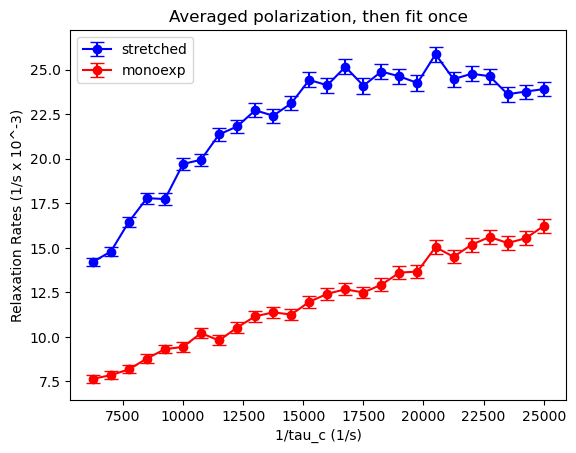

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [311]:
stretched_mean = np.mean(stretched_rate, axis=1)
mono_mean = np.mean(mono_rate, axis=1)

stretched_error = (np.sqrt(np.var(stretched_rate, axis=1)/iterations))
mono_error = (np.sqrt(np.var(mono_rate, axis=1)/iterations))

# fig = plt.figure()
# plt.errorbar((1/tau_c), stretched_mean, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
# plt.errorbar((1/tau_c), mono_mean, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
# plt.title("Fit all trajectories, then averaged rates")
# plt.xlabel("1/tau_c (1/s)")
# plt.ylabel("Relaxation Rates (1/s x 10^-3)")
# plt.legend()
# plt.show()

fig = plt.figure()
plt.errorbar((1/tau_c), stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
plt.errorbar((1/tau_c), mono_avg, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

filename = f"Regime1_500Itr_v2.npz"
np.savez(filename, corr_time = tau_c, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

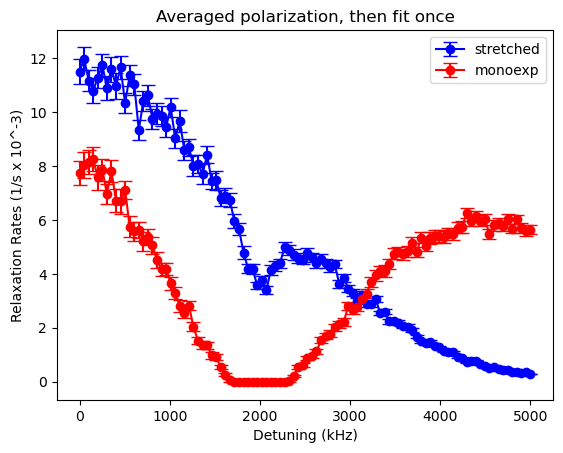

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [187]:
stretched_mean = np.mean(stretched_rate, axis=1)
mono_mean = np.mean(mono_rate, axis=1)

stretched_error = (np.sqrt(np.var(stretched_rate, axis=1)/iterations))
mono_error = (np.sqrt(np.var(mono_rate, axis=1)/iterations))

# fig = plt.figure()
# plt.errorbar((1/tau_c), stretched_mean, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
# plt.errorbar((1/tau_c), mono_mean, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
# plt.title("Fit all trajectories, then averaged rates")
# plt.xlabel("1/tau_c (1/s)")
# plt.ylabel("Relaxation Rates (1/s x 10^-3)")
# plt.legend()
# plt.show()

fig = plt.figure()
plt.errorbar(offset, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
plt.errorbar(offset, mono_avg, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
plt.xlabel("Detuning (kHz)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

# filename = f"OffsetMonteCarlo_100Itr.npz"
# np.savez(filename, detuning = offset, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\OffsetMonteCarloV2.eps", format='eps', dpi=300)

In [184]:
from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    from scipy.linalg import expm
    from scipy.linalg import logm
    from scipy.linalg import eig, eigh
    from scipy.linalg import null_space
    from scipy.sparse.linalg import expm_multiply
    from scipy.integrate import simps 

    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*2717
#     w_eff2 = 2*np.pi*3878
#     w_eff3 = 2*np.pi*5008
    
    def calculate_scaling_dd(w_rabi, offset, pulselength, delay, dt):

        #Define basis states and spin operators
        upup = np.array([1,0,0,0]).reshape(4,1)
        updown = np.array([0,1,0,0]).reshape(4,1)
        downup = np.array([0,0,1,0]).reshape(4,1)
        downdown = np.array([0,0,0,1]).reshape(4,1)

        S_plus = np.array([[0,0,1,0], [0,0,0,1], [0,0,0,0], [0,0,0,0]])
        S_minus = np.array([[0,0,0,0], [0,0,0,0], [1,0,0,0], [0,1,0,0]])
        I_plus = np.array([[0,1,0,0], [0,0,0,0], [0,0,0,1], [0,0,0,0]])
        I_minus = np.array([[0,0,0,0], [1,0,0,0], [0,0,0,0], [0,0,1,0]])

        S_x = (1/2)*(S_plus + S_minus)
        S_y = (1/2j)*(S_plus - S_minus)
        I_x = (1/2)*(I_plus + I_minus)
        I_y = (1/2j)*(I_plus - I_minus)

        S_z = (1/2)*np.diag([1,1,-1,-1])
        I_z = (1/2)*np.diag([1,-1,1,-1])

        Id = np.diag([1,1,1,1])


        #Define experiment parameters and Hamiltonians
        time = np.linspace(0, pulselength+delay, int((pulselength+delay)/dt))

        H = -(I_x @ S_x) - (I_y @ S_y) + 2*(I_z @ S_z)
    #     H = I_z + S_z

        H_pulse = 2*np.pi*w_rabi*(I_x + S_x) + 2*np.pi*offset*(I_z + S_z)
        H_delay = 2*np.pi*offset*(I_z + S_z)


        #Calculate the effective rotation axis
        U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength)
        R_eff = 1j*logm(U_final)

        norm = abs(np.trace(R_eff @ R_eff.conj().T))

        mu_x = (np.trace(R_eff @ I_x.conj().T)/norm).real
        mu_y = (np.trace(R_eff @ I_y.conj().T)/norm).real
        mu_z = (np.trace(R_eff @ I_z.conj().T)/norm).real

        r = np.sqrt(mu_x**2 + mu_y**2 + mu_z**2)
        theta_eff = (np.arccos(mu_z/r))*(180/np.pi)


        ###Calculate effective H_dd as a function of time in the interaction picture of just the periodic part of the pulse sequence
        H_eff = np.zeros((len(time), 4, 4), dtype='complex')

        for t in range(len(time)):
            if t < int(pulselength/dt):
                U_rf = expm(-1j*H_pulse*time[t])
                U_eff = expm(1j*R_eff*time[t])
                P = U_rf @ U_eff
                H_eff[t,:,:] = P.conj().T @ H @ P
            else:
                U_rf = expm(-1j*H_delay*(time[t]-pulselength)) @ expm(-1j*H_pulse*pulselength)
                U_eff = expm(1j*R_eff*time[t])
                P = U_rf @ U_eff
                H_eff[t,:,:] = P.conj().T @ H @ P



        ###Calculate average effective H_dd in the interaction picture of just the periodic part of the pulse sequence by 
        #integrating over time
        H_eff_avg = np.zeros((4, 4), dtype='complex')

        for m in range(4):
            for n in range(4):
                H_eff_avg[m,n] = simps(H_eff[:,m,n], time)

        H_eff_avg = (1/(pulselength+delay))*H_eff_avg



        ###Define I_mu and find the component of H_tilde_dd_avg commutes with I_mu
        I_mu = mu_x*(I_x+S_x) + mu_y*(I_y+S_y) + mu_z*(I_z+S_z)

        # I_mu*X - X*I_mu = 0 → (I_mu⊗Id - Id⊗I_Mu.T)vec(X) = 0 
        K = np.kron(I_mu, Id) - np.kron(Id, I_mu.T)
        #nullspace of K represents basis for space of solutions X which commute with I_mu
        null_basis = null_space(K)

        #Project H_eff_dd_avg onto null_basis
        H_vec = H_eff_avg.flatten()
        H_proj = np.zeros_like(H_vec)

        for i in range(null_basis.shape[1]):
            v = null_basis[:,i]
            H_coeff = (H_vec @ v.conj())/(v @ v.conj())
            H_proj = H_proj + H_coeff*v

        H_avg_secular = H_proj.reshape(4,4)

        scaling_factor = (np.sqrt(2/3*np.trace(H_avg_secular @ H_avg_secular.conj().T))).real

        return theta_eff, scaling_factor

    
    
    def calculate_scaling_hf(w_rabi, offset, pulselength, delay, dt):

        #Define basis states and spin operators
        upup = np.array([1,0,0,0]).reshape(4,1)
        updown = np.array([0,1,0,0]).reshape(4,1)
        downup = np.array([0,0,1,0]).reshape(4,1)
        downdown = np.array([0,0,0,1]).reshape(4,1)

        S_plus = np.array([[0,0,1,0], [0,0,0,1], [0,0,0,0], [0,0,0,0]])
        S_minus = np.array([[0,0,0,0], [0,0,0,0], [1,0,0,0], [0,1,0,0]])
        I_plus = np.array([[0,1,0,0], [0,0,0,0], [0,0,0,1], [0,0,0,0]])
        I_minus = np.array([[0,0,0,0], [1,0,0,0], [0,0,0,0], [0,0,1,0]])

        S_x = (1/2)*(S_plus + S_minus)
        S_y = (1/2j)*(S_plus - S_minus)
        I_x = (1/2)*(I_plus + I_minus)
        I_y = (1/2j)*(I_plus - I_minus)

        S_z = (1/2)*np.diag([1,1,-1,-1])
        I_z = (1/2)*np.diag([1,-1,1,-1])

        Id = np.diag([1,1,1,1])


        #Define experiment parameters and Hamiltonians
        time = np.linspace(0, pulselength+delay, int((pulselength+delay)/dt))

    #     H_dd = -(I_x @ S_x) - (I_y @ S_y) + 2*(I_z @ S_z)
        H = I_z + S_z

        H_pulse = 2*np.pi*w_rabi*(I_x + S_x) + 2*np.pi*offset*(I_z + S_z)
        H_delay = 2*np.pi*offset*(I_z + S_z)


        #Calculate the effective rotation axis
        U_final = expm(-1j*H_delay*delay) @ expm(-1j*H_pulse*pulselength)
        R_eff = 1j*logm(U_final)

        norm = abs(np.trace(R_eff @ R_eff.conj().T))

        mu_x = (np.trace(R_eff @ I_x.conj().T)/norm).real
        mu_y = (np.trace(R_eff @ I_y.conj().T)/norm).real
        mu_z = (np.trace(R_eff @ I_z.conj().T)/norm).real

        r = np.sqrt(mu_x**2 + mu_y**2 + mu_z**2)
        theta_eff = (np.arccos(mu_z/r))*(180/np.pi)


        ###Calculate effective H_dd as a function of time in the interaction picture of just the periodic part of the pulse sequence
        H_eff = np.zeros((len(time), 4, 4), dtype='complex')

        for t in range(len(time)):
            if t < int(pulselength/dt):
                U_rf = expm(-1j*H_pulse*time[t])
                U_eff = expm(1j*R_eff*time[t])
                P = U_rf @ U_eff
                H_eff[t,:,:] = P.conj().T @ H @ P
            else:
                U_rf = expm(-1j*H_delay*(time[t]-pulselength)) @ expm(-1j*H_pulse*pulselength)
                U_eff = expm(1j*R_eff*time[t])
                P = U_rf @ U_eff
                H_eff[t,:,:] = P.conj().T @ H @ P



        ###Calculate average effective H_dd in the interaction picture of just the periodic part of the pulse sequence by 
        #integrating over time
        H_eff_avg = np.zeros((4, 4), dtype='complex')

        for m in range(4):
            for n in range(4):
                H_eff_avg[m,n] = simps(H_eff[:,m,n], time)

        H_eff_avg = (1/(pulselength+delay))*H_eff_avg



        ###Define I_mu and find the component of H_tilde_dd_avg commutes with I_mu
        I_mu = mu_x*(I_x+S_x) + mu_y*(I_y+S_y) + mu_z*(I_z+S_z)

        # I_mu*X - X*I_mu = 0 → (I_mu⊗Id - Id⊗I_Mu.T)vec(X) = 0 
        K = np.kron(I_mu, Id) - np.kron(Id, I_mu.T)
        #nullspace of K represents basis for space of solutions X which commute with I_mu
        null_basis = null_space(K)

        #Project H_eff_dd_avg onto null_basis
        H_vec = H_eff_avg.flatten()
        H_proj = np.zeros_like(H_vec)

        for i in range(null_basis.shape[1]):
            v = null_basis[:,i]
            H_coeff = (H_vec @ v.conj())/(v @ v.conj())
            H_proj = H_proj + H_coeff*v

        H_avg_secular = H_proj.reshape(4,4)

        H_avg_nonsecular = H_eff_avg - H_avg_secular

        scaling_factor = (np.sqrt(1/2*np.trace(H_avg_nonsecular @ H_avg_nonsecular.conj().T))).real

        return theta_eff, scaling_factor

    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 56e-6
        delay = 36e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M


    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    offset = params
    
    tau_p = 1.5e-6
    tau_d = 3e-2
    
    size = 12
    T = np.linspace(0,500,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    theta_dd, dd_scaling_factor = calculate_scaling_dd(1/(4*56e-6), offset, 56e-6, 36e-6, 100e-9)
    theta_hf, hf_scaling_factor = calculate_scaling_hf(1/(4*56e-6), offset, 56e-6, 36e-6, 100e-9)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p*hf_scaling_factor**2, tau_d*dd_scaling_factor**2)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


import time

def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate    
    
    
N = 100 #Number of offset values

iterations = 100
offset = np.linspace(0, 5e3, N)
# tau_p = 0.105*np.ones(N)
# tau_d = 1e-2*np.linspace(1.5, 0.7, N)
# tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, N))

stretched_rate = np.zeros((N,iterations))
mono_rate = np.zeros((N,iterations))

stretched_avg = np.zeros(N)
mono_avg = np.zeros(N)

for i in range(N):
    print(f"Running offset value = {i}")
    start_time = time.time()
    
    inputs = [(offset[i])] * iterations 
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
    pool.close()
    pool.join()

    T = np.linspace(0,500,100)
    P = np.array(results)
    
    for j in range(iterations):
        stretched_rate[i,j], mono_rate[i,j] = fit_product(P[j,:],T)
        
    P_avg = (np.sum(np.array(results), axis=0))/iterations
    
    stretched_avg[i], mono_avg[i] = fit_product(P_avg,T)
    
    print(f"Offset value {i} completed in {time.time() - start_time:.2f} seconds")

Running offset value = 0
Offset value 0 completed in 103.53 seconds
Running offset value = 1
Offset value 1 completed in 95.83 seconds
Running offset value = 2
Offset value 2 completed in 98.85 seconds
Running offset value = 3
Offset value 3 completed in 91.42 seconds
Running offset value = 4
Offset value 4 completed in 92.14 seconds
Running offset value = 5
Offset value 5 completed in 87.48 seconds
Running offset value = 6
Offset value 6 completed in 99.34 seconds
Running offset value = 7
Offset value 7 completed in 97.28 seconds
Running offset value = 8
Offset value 8 completed in 94.32 seconds
Running offset value = 9
Offset value 9 completed in 82.51 seconds
Running offset value = 10
Offset value 10 completed in 94.88 seconds
Running offset value = 11
Offset value 11 completed in 78.62 seconds
Running offset value = 12
Offset value 12 completed in 83.48 seconds
Running offset value = 13
Offset value 13 completed in 85.12 seconds
Running offset value = 14
Offset value 14 completed i

In [ ]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*3205
    w_eff2 = 2*np.pi*3878
    w_eff3 = 2*np.pi*5008
    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 38e-6
        delay = 40e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)
        
        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
#                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)
            
                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_c, tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,300,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p*calculate_eta(w_eff1, tau_c), tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


import time

def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate    
    
    
N = 26 #Number of tau_c values

iterations = 300
tau_p = 1.45e-3*np.ones(N)
tau_d = np.linspace(5e-5, 2.5e-5, N)
tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, N))

stretched_rate = np.zeros((N,iterations))
mono_rate = np.zeros((N,iterations))

stretched_avg = np.zeros(N)
mono_avg = np.zeros(N)

for i in range(N):
    print(f"Running tau_c value = {i}")
    start_time = time.time()
    
    inputs = [(tau_c[i], tau_p[i], tau_d[i])] * iterations 
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
#     pool.close()
#     pool.join()

    T = np.linspace(0,300,100)
    P = np.array(results)
    
    for j in range(iterations):
        stretched_rate[i,j], mono_rate[i,j] = fit_product(P[j,:],T)
        
    P_avg = (np.sum(np.array(results), axis=0))/iterations
    
    stretched_avg[i], mono_avg[i] = fit_product(P_avg,T)
    
    print(f"Tau_c value {i} completed in {time.time() - start_time:.2f} seconds")

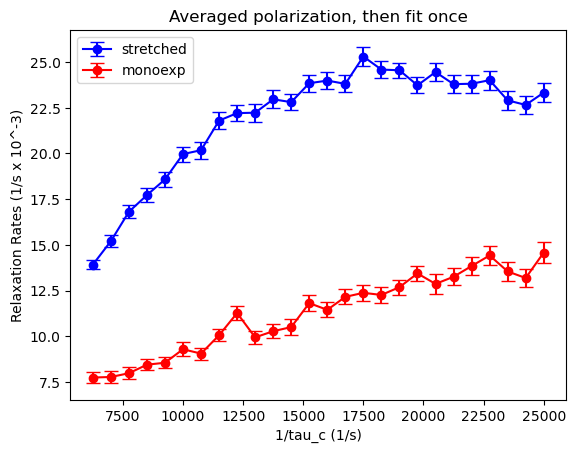

In [53]:
stretched_mean = np.mean(stretched_rate, axis=1)
mono_mean = np.mean(mono_rate, axis=1)

stretched_error = (np.sqrt(np.var(stretched_rate, axis=1)/iterations))
mono_error = (np.sqrt(np.var(mono_rate, axis=1)/iterations))

fig = plt.figure()
plt.errorbar((1/tau_c), stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
plt.errorbar((1/tau_c), mono_avg, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

filename = f"Regime1_500Itr_PBC_v1.npz"
np.savez(filename, corr_time = tau_c, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_PBC.eps", format='eps', dpi=300)

In [10]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*3205
    w_eff2 = 2*np.pi*3878
    w_eff3 = 2*np.pi*5008
    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 38e-6
        delay = 40e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)
        
        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
#                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)
            
                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_c, tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,500,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p*calculate_eta(w_eff2, tau_c), tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


import time

def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate    
    
    
N = 26 #Number of tau_c values

iterations = 500
tau_p = 1.45*1.35e-3*np.ones(N)
tau_d = 0*np.linspace(5e-5, 2.5e-5, N)
tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, N))

stretched_rate = np.zeros((N,iterations))
mono_rate = np.zeros((N,iterations))

stretched_avg = np.zeros(N)
mono_avg = np.zeros(N)

for i in range(N):
    print(f"Running tau_c value = {i}")
    start_time = time.time()
    
    inputs = [(tau_c[i], tau_p[i], tau_d[i])] * iterations 
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
#     pool.close()
#     pool.join()

    T = np.linspace(0,500,100)
    P = np.array(results)
    
    for j in range(iterations):
        stretched_rate[i,j], mono_rate[i,j] = fit_product(P[j,:],T)
        
    P_avg = (np.sum(np.array(results), axis=0))/iterations
    
    stretched_avg[i], mono_avg[i] = fit_product(P_avg,T)
    
    print(f"Tau_c value {i} completed in {time.time() - start_time:.2f} seconds")

Running tau_c value = 0
Tau_c value 0 completed in 1847.63 seconds
Running tau_c value = 1
Tau_c value 1 completed in 1877.38 seconds
Running tau_c value = 2
Tau_c value 2 completed in 1771.78 seconds
Running tau_c value = 3
Tau_c value 3 completed in 1892.06 seconds
Running tau_c value = 4
Tau_c value 4 completed in 1875.25 seconds
Running tau_c value = 5
Tau_c value 5 completed in 1887.27 seconds
Running tau_c value = 6
Tau_c value 6 completed in 1885.81 seconds
Running tau_c value = 7
Tau_c value 7 completed in 1893.31 seconds
Running tau_c value = 8
Tau_c value 8 completed in 1877.14 seconds
Running tau_c value = 9
Tau_c value 9 completed in 1895.85 seconds
Running tau_c value = 10
Tau_c value 10 completed in 1861.26 seconds
Running tau_c value = 11
Tau_c value 11 completed in 1873.66 seconds
Running tau_c value = 12
Tau_c value 12 completed in 1873.99 seconds
Running tau_c value = 13
Tau_c value 13 completed in 1821.83 seconds
Running tau_c value = 14
Tau_c value 14 completed in 1

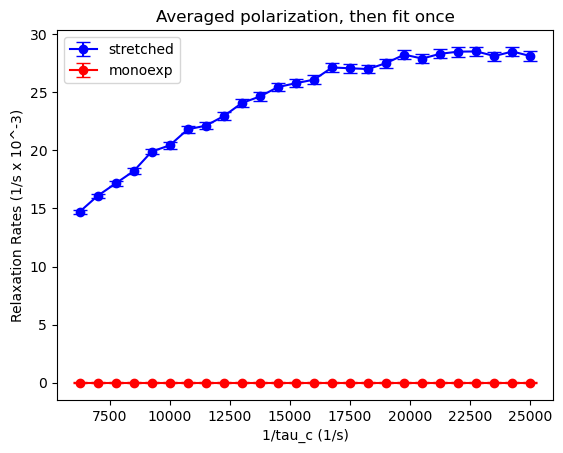

In [11]:
stretched_mean = np.mean(stretched_rate, axis=1)
mono_mean = np.mean(mono_rate, axis=1)

stretched_error = (np.sqrt(np.var(stretched_rate, axis=1)/iterations))
mono_error = (np.sqrt(np.var(mono_rate, axis=1)/iterations))

fig = plt.figure()
plt.errorbar((1/tau_c), stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
plt.errorbar((1/tau_c), mono_avg, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

filename = f"Regime2_500Itr_PBC_v1.npz"
np.savez(filename, corr_time = tau_c, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime2_PBC.eps", format='eps', dpi=300)

In [46]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*3205
    w_eff2 = 2*np.pi*3878
    w_eff3 = 2*np.pi*5008
    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 2e-6
        delay = 40e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)
        
        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
#                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)
            
                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_c, tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,2000,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p*calculate_eta(w_eff3, tau_c), tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


import time

def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate    
    
    
N = 26 #Number of tau_c values

iterations = 100
tau_p = 0.0275*1.25e-3*np.ones(N)
tau_d = np.linspace(5e-5, 2.5e-5, N)
tau_c = 1/(np.linspace(1/4e-5, 1/1.6e-4, N))

stretched_rate = np.zeros((N,iterations))
mono_rate = np.zeros((N,iterations))

stretched_avg = np.zeros(N)
mono_avg = np.zeros(N)

for i in range(N):
    print(f"Running tau_c value = {i}")
    start_time = time.time()
    
    inputs = [(tau_c[i], tau_p[i], tau_d[i])] * iterations 
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
#     pool.close()
#     pool.join()

    T = np.linspace(0,2000,100)
    P = np.array(results)
    
    for j in range(iterations):
        stretched_rate[i,j], mono_rate[i,j] = fit_product(P[j,:],T)
        
    P_avg = (np.sum(np.array(results), axis=0))/iterations
    
    stretched_avg[i], mono_avg[i] = fit_product(P_avg,T)
    
    print(f"Tau_c value {i} completed in {time.time() - start_time:.2f} seconds")

Running tau_c value = 0
Tau_c value 0 completed in 319.51 seconds
Running tau_c value = 1
Tau_c value 1 completed in 336.05 seconds
Running tau_c value = 2
Tau_c value 2 completed in 275.68 seconds
Running tau_c value = 3
Tau_c value 3 completed in 282.01 seconds
Running tau_c value = 4
Tau_c value 4 completed in 347.68 seconds
Running tau_c value = 5
Tau_c value 5 completed in 282.13 seconds
Running tau_c value = 6
Tau_c value 6 completed in 298.43 seconds
Running tau_c value = 7
Tau_c value 7 completed in 278.23 seconds
Running tau_c value = 8
Tau_c value 8 completed in 324.72 seconds
Running tau_c value = 9
Tau_c value 9 completed in 311.30 seconds
Running tau_c value = 10
Tau_c value 10 completed in 259.53 seconds
Running tau_c value = 11
Tau_c value 11 completed in 331.22 seconds
Running tau_c value = 12
Tau_c value 12 completed in 350.78 seconds
Running tau_c value = 13
Tau_c value 13 completed in 341.99 seconds
Running tau_c value = 14
Tau_c value 14 completed in 333.01 seconds


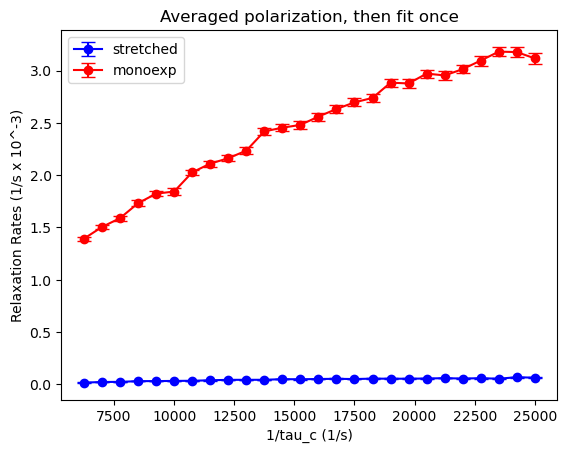

In [47]:
stretched_mean = np.mean(stretched_rate, axis=1)
mono_mean = np.mean(mono_rate, axis=1)

stretched_error = (np.sqrt(np.var(stretched_rate, axis=1)/iterations))
mono_error = (np.sqrt(np.var(mono_rate, axis=1)/iterations))

fig = plt.figure()
plt.errorbar((1/tau_c), stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
plt.errorbar((1/tau_c), mono_avg, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

# filename = f"Regime3_100Itr_PBC.npz"
# np.savez(filename, corr_time = tau_c, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime3_PBC.eps", format='eps', dpi=300)

In [35]:
#Run different lattice configurations simultaneously using different CPU cores
#Then average over different iterations, fit, and extract rates
#Repeat all of this for different values of tau_p and tau_d

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def open_txt(inputstring):
        with open(inputstring, 'r') as f:
            contents = f.read()
        cleaned = contents.replace(',', ' ').replace('\n', ' ').split()
        array = np.array([float(val) for val in cleaned])
        x = array[::2]
        y = array[1::2]
        return x, y

    x1, y1 = open_txt('Regime1.txt')
    x2, y2 = open_txt('Regime2.txt')
    x3, y3 = open_txt('Regime3.txt')
    
    w_eff1 = 2*np.pi*3205
    w_eff2 = 2*np.pi*3878
    w_eff3 = 2*np.pi*5008
    
    def calculate_eta(w_eff, tau_c):

        def J(w, tau_c):
            return (tau_c)/(1 + (w*tau_c)**2)

        pulselength = 38e-6
        delay = 40e-6
        omega = (2*np.pi) / (pulselength + delay)

        eta = 0
        for k in range(510,515):
            eta += y1[k]*J(w_eff + x1[k]*omega, tau_c) + y1[k]*J(w_eff - x1[k]*omega, tau_c)

        return eta

    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)
        
        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
#                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)
            
                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_c, tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,600,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p*calculate_eta(w_eff1, tau_c), tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


import time

def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate    
    
    
N = 100 #Number of tau_c values

iterations = 100
tau_p = 1.45e-3*np.ones(N)
tau_d = 2.5e-5*np.ones(N) 
tau_c = 1/(np.linspace(1/2e-6, 1/1.6e-4, N))

stretched_rate = np.zeros((N,iterations))
mono_rate = np.zeros((N,iterations))

stretched_avg = np.zeros(N)
mono_avg = np.zeros(N)

for i in range(N):
    print(f"Running tau_c value = {i}")
    start_time = time.time()
    
    inputs = [(tau_c[i], tau_p[i], tau_d[i])] * iterations 
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
#     pool.close()
#     pool.join()

    T = np.linspace(0,600,100)
    P = np.array(results)
    
    for j in range(iterations):
        stretched_rate[i,j], mono_rate[i,j] = fit_product(P[j,:],T)
        
    P_avg = (np.sum(np.array(results), axis=0))/iterations
    
    stretched_avg[i], mono_avg[i] = fit_product(P_avg,T)
    
    print(f"Tau_c value {i} completed in {time.time() - start_time:.2f} seconds")

Running tau_c value = 0
Tau_c value 0 completed in 267.56 seconds
Running tau_c value = 1
Tau_c value 1 completed in 293.99 seconds
Running tau_c value = 2
Tau_c value 2 completed in 319.82 seconds
Running tau_c value = 3
Tau_c value 3 completed in 254.93 seconds
Running tau_c value = 4
Tau_c value 4 completed in 327.78 seconds
Running tau_c value = 5
Tau_c value 5 completed in 313.07 seconds
Running tau_c value = 6
Tau_c value 6 completed in 329.53 seconds
Running tau_c value = 7
Tau_c value 7 completed in 252.87 seconds
Running tau_c value = 8
Tau_c value 8 completed in 323.49 seconds
Running tau_c value = 9
Tau_c value 9 completed in 339.07 seconds
Running tau_c value = 10
Tau_c value 10 completed in 276.84 seconds
Running tau_c value = 11
Tau_c value 11 completed in 321.80 seconds
Running tau_c value = 12
Tau_c value 12 completed in 343.17 seconds
Running tau_c value = 13
Tau_c value 13 completed in 329.73 seconds
Running tau_c value = 14
Tau_c value 14 completed in 295.73 seconds


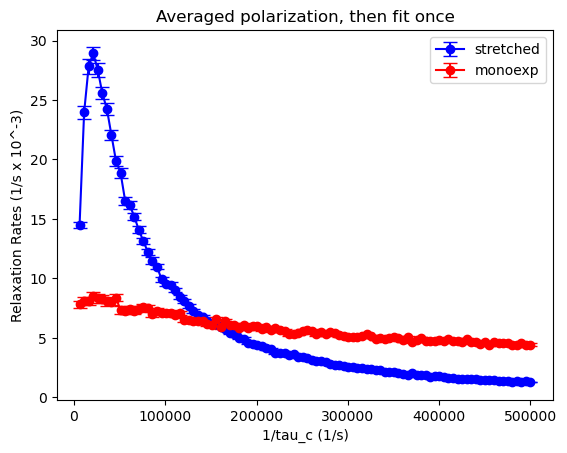

In [36]:
stretched_mean = np.mean(stretched_rate, axis=1)
mono_mean = np.mean(mono_rate, axis=1)

stretched_error = (np.sqrt(np.var(stretched_rate, axis=1)/iterations))
mono_error = (np.sqrt(np.var(mono_rate, axis=1)/iterations))

fig = plt.figure()
plt.errorbar((1/tau_c), stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
plt.errorbar((1/tau_c), mono_avg, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

filename = f"AllOpticalDecouple_100Itr_PBC.npz"
np.savez(filename, corr_time = tau_c, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime3_PBC.eps", format='eps', dpi=300)

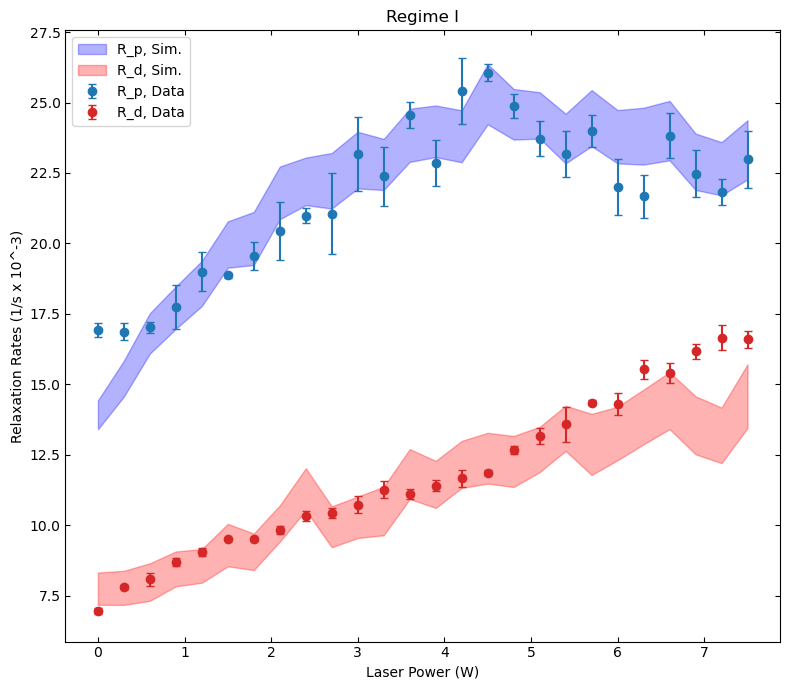

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [40]:
# Load the data, skipping the header
data = np.loadtxt('Regime1_Data.txt', skiprows=1)

# Extract columns
input_array = data[:, 0]
rate1_avg = data[:, 1]
rate1_error = data[:, 2]
rate2_avg = data[:, 3]
rate2_error = data[:, 4]

# Plot
fig = plt.figure(figsize=(8, 7))

# Plot Rate 1
plt.errorbar(input_array, rate1_avg, yerr=rate1_error, fmt='o',
             color='tab:blue', label='R_p, Data', markersize=6, capsize=3)

# Plot Rate 2
plt.errorbar(input_array, rate2_avg, yerr=rate2_error, fmt='o',
             color='tab:red', label='R_d, Data', markersize=6, capsize=3)


# Load the npz file
data = np.load('Regime1_100Itr_PBC_v5.npz')

# Extract arrays
tau_c = data['corr_time']
stretched_rate = data['S']
mono_rate = data['M']
stretched_avg = data['S_avg']
mono_avg = data['M_avg']

# Infer number of iterations from array shape
iterations = stretched_rate.shape[1]

# Compute error bars
stretched_error = 2*np.sqrt(np.var(stretched_rate, axis=1) / iterations)
mono_error = 2*np.sqrt(np.var(mono_rate, axis=1) / iterations)

reverse_idx = np.argsort(input_array)[::-1]

input_array_reversed = input_array[reverse_idx]
stretched_avg_rev = stretched_avg[reverse_idx]
mono_avg_rev = mono_avg[reverse_idx]
stretched_error_rev = stretched_error[reverse_idx]
mono_error_rev = mono_error[reverse_idx]


# # Plot the inverse correlation time vs rates
# plt.errorbar(input_array, stretched_avg_rev, yerr=stretched_error_rev, fmt='-o',
#              capsize=5, capthick=1, color='blue', label='R_p, Sim.')
# plt.errorbar(input_array, mono_avg_rev, yerr=mono_error_rev, fmt='-o',
#              capsize=5, capthick=1, color='red', label='R_d, Sim.')

# Plot shaded error region for stretched_avg
plt.fill_between(input_array, 
                 stretched_avg_rev - stretched_error_rev, 
                 stretched_avg_rev + stretched_error_rev,
                 color='blue', alpha=0.3, label='R_p, Sim.')

# Plot shaded error region for mono_avg
plt.fill_between(input_array, 
                 mono_avg_rev - mono_error_rev, 
                 mono_avg_rev + mono_error_rev,
                 color='red', alpha=0.3, label='R_d, Sim.')

# ----- Final plot formatting -----
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('Laser Power (W)')
plt.ylabel('Relaxation Rates (1/s x 10^-3)')
plt.title('Regime I')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\RegimeI.eps", format='eps', dpi=300)

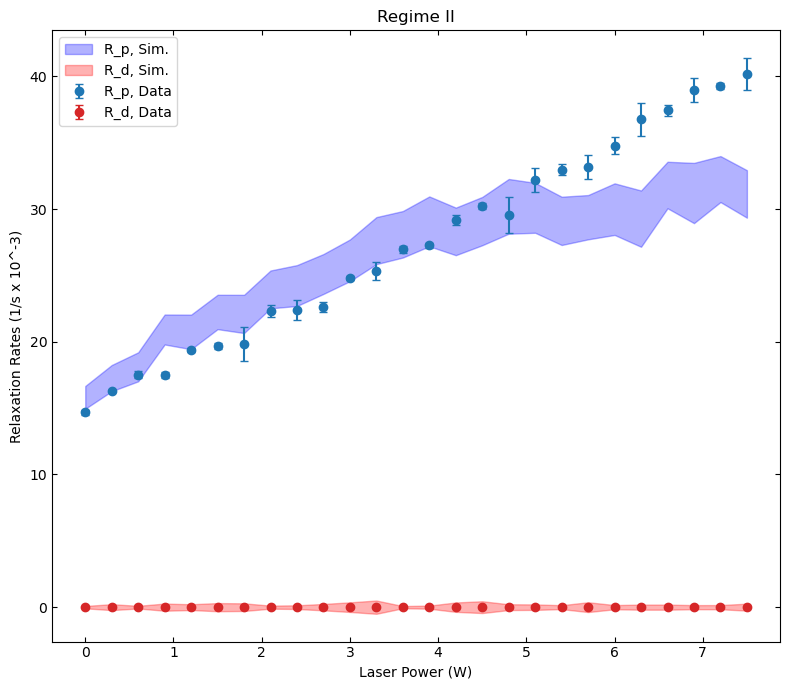

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [39]:
# Load the data, skipping the header
data = np.loadtxt('Regime2_Data.txt', skiprows=1)

# Extract columns
input_array = data[:, 0]
rate1_avg = data[:, 1]
rate1_error = data[:, 2]
rate2_avg = data[:, 3]
rate2_error = data[:, 4]

# Plot
fig = plt.figure(figsize=(8, 7))

# Plot Rate 1
plt.errorbar(input_array, rate1_avg, yerr=rate1_error, fmt='o',
             color='tab:blue', label='R_p, Data', markersize=6, capsize=3)

# Plot Rate 2
plt.errorbar(input_array, rate2_avg, yerr=rate2_error, fmt='o',
             color='tab:red', label='R_d, Data', markersize=6, capsize=3)


# Load the npz file
data = np.load('Regime2_100Itr_PBC_v4.npz')

# Extract arrays
tau_c = data['corr_time']
stretched_rate = data['S']
mono_rate = data['M']
stretched_avg = data['S_avg']
mono_avg = data['M_avg']

# Infer number of iterations from array shape
iterations = stretched_rate.shape[1]

# Compute error bars
stretched_error = 2*np.sqrt(np.var(stretched_rate, axis=1) / iterations)
mono_error = 10*np.sqrt(np.var(mono_rate, axis=1) / iterations)

reverse_idx = np.argsort(input_array)[::-1]

input_array_reversed = input_array[reverse_idx]
stretched_avg_rev = stretched_avg[reverse_idx]
mono_avg_rev = mono_avg[reverse_idx]
stretched_error_rev = stretched_error[reverse_idx]
mono_error_rev = mono_error[reverse_idx]


# # Plot the inverse correlation time vs rates
# plt.errorbar(input_array, stretched_avg_rev, yerr=stretched_error_rev, fmt='-o',
#              capsize=5, capthick=1, color='blue', label='R_p, Sim.')
# plt.errorbar(input_array, mono_avg_rev, yerr=mono_error_rev, fmt='-o',
#              capsize=5, capthick=1, color='red', label='R_d, Sim.')

# Plot shaded error region for stretched_avg
plt.fill_between(input_array, 
                 stretched_avg_rev - stretched_error_rev, 
                 stretched_avg_rev + stretched_error_rev,
                 color='blue', alpha=0.3, label='R_p, Sim.')

# Plot shaded error region for mono_avg
plt.fill_between(input_array, 
                 mono_avg_rev - mono_error_rev, 
                 mono_avg_rev + mono_error_rev,
                 color='red', alpha=0.3, label='R_d, Sim.')


# ----- Final plot formatting -----
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('Laser Power (W)')
plt.ylabel('Relaxation Rates (1/s x 10^-3)')
plt.title('Regime II')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\RegimeII.eps", format='eps', dpi=300)

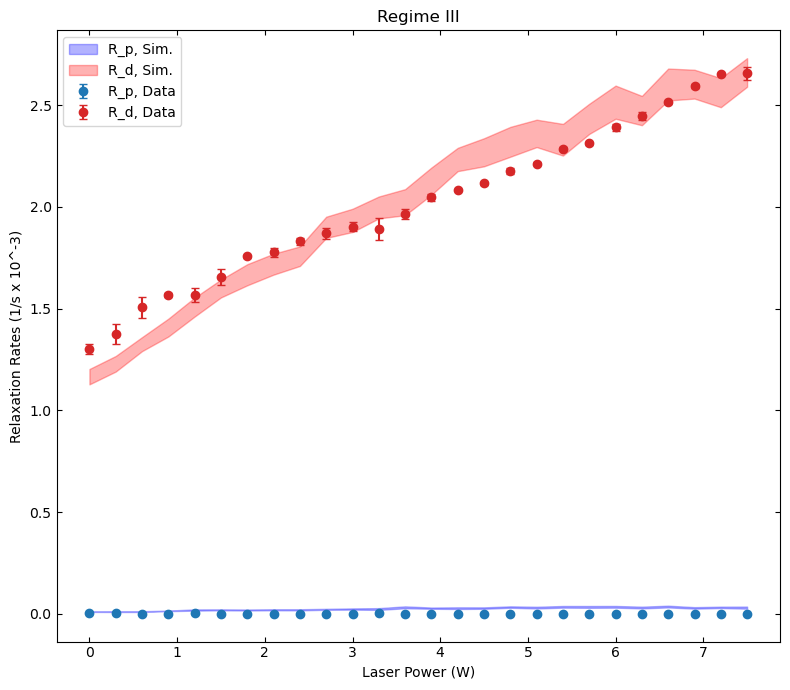

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [37]:
# Load the data, skipping the header
data = np.loadtxt('Regime3_Data.txt', skiprows=1)

# Extract columns
input_array = data[:, 0]
rate1_avg = data[:, 1]
rate1_error = data[:, 2]
rate2_avg = data[:, 3]
rate2_error = data[:, 4]

# Plot
fig = plt.figure(figsize=(8, 7))

# Plot Rate 1
plt.errorbar(input_array, rate1_avg, yerr=rate1_error, fmt='o',
             color='tab:blue', label='R_p, Data', markersize=6, capsize=3)

# Plot Rate 2
plt.errorbar(input_array, rate2_avg, yerr=rate2_error, fmt='o',
             color='tab:red', label='R_d, Data', markersize=6, capsize=3)


# Load the npz file
data = np.load('Regime3_100Itr_PBC_v4.npz')

# Extract arrays
tau_c = data['corr_time']
stretched_rate = data['S']
mono_rate = data['M']
stretched_avg = data['S_avg']
mono_avg = data['M_avg']

# Infer number of iterations from array shape
iterations = stretched_rate.shape[1]

# Compute error bars
stretched_error = 2*np.sqrt(np.var(stretched_rate, axis=1) / iterations)
mono_error = 2*np.sqrt(np.var(mono_rate, axis=1) / iterations)

reverse_idx = np.argsort(input_array)[::-1]

input_array_reversed = input_array[reverse_idx]
stretched_avg_rev = stretched_avg[reverse_idx]
mono_avg_rev = mono_avg[reverse_idx]
stretched_error_rev = stretched_error[reverse_idx]
mono_error_rev = mono_error[reverse_idx]


# # Plot the inverse correlation time vs rates
# plt.errorbar(input_array, stretched_avg_rev, yerr=stretched_error_rev, fmt='-o',
#              capsize=5, capthick=1, color='blue', label='R_p, Sim.')
# plt.errorbar(input_array, mono_avg_rev, yerr=mono_error_rev, fmt='-o',
#              capsize=5, capthick=1, color='red', label='R_d, Sim.')

# Plot shaded error region for stretched_avg
plt.fill_between(input_array, 
                 stretched_avg_rev - stretched_error_rev, 
                 stretched_avg_rev + stretched_error_rev,
                 color='blue', alpha=0.3, label='R_p, Sim.')

# Plot shaded error region for mono_avg
plt.fill_between(input_array, 
                 mono_avg_rev - mono_error_rev, 
                 mono_avg_rev + mono_error_rev,
                 color='red', alpha=0.3, label='R_d, Sim.')

# ----- Final plot formatting -----
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('Laser Power (W)')
plt.ylabel('Relaxation Rates (1/s x 10^-3)')
plt.title('Regime III')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\RegimeIII.eps", format='eps', dpi=300)

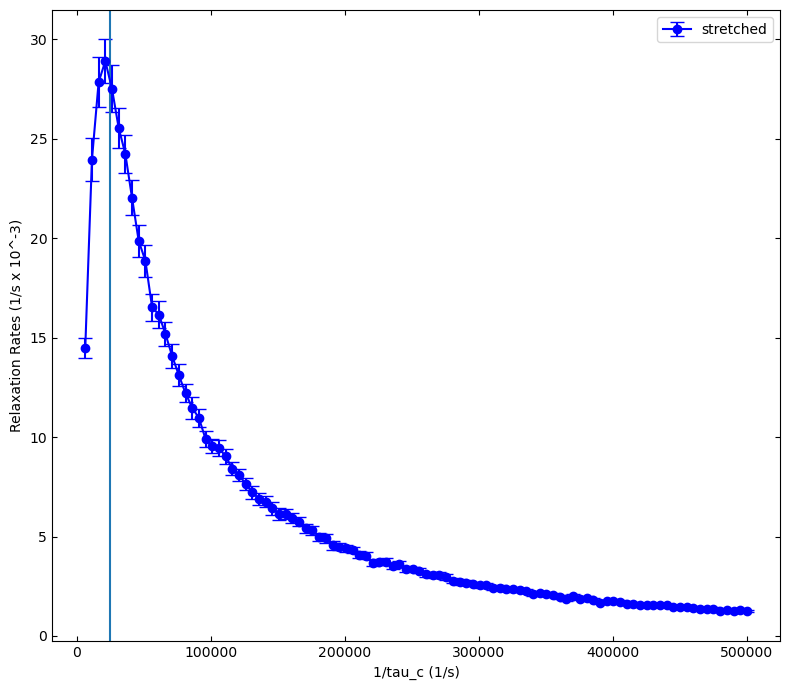

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [45]:
# Load the npz file
data = np.load('AllOpticalDecouple_100Itr_PBC.npz')

# Extract arrays
tau_c = data['corr_time']
stretched_rate = data['S']
mono_rate = data['M']
stretched_avg = data['S_avg']
mono_avg = data['M_avg']

# Infer number of iterations from array shape
iterations = stretched_rate.shape[1]

# Compute error bars
stretched_error = 2*np.sqrt(np.var(stretched_rate, axis=1) / iterations)
mono_error = 2*np.sqrt(np.var(mono_rate, axis=1) / iterations)

fig = plt.figure(figsize=(8, 7))
plt.errorbar((1/tau_c), stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=1, color = 'blue', label = 'stretched')
# plt.errorbar((1/tau_c), mono_avg, mono_error, fmt='-o', capsize=5, capthick=1, color = 'red', label = 'monoexp') 
plt.axvline(1/4e-5)
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\AllOpticalDecouple_PBC.eps", format='eps', dpi=300)

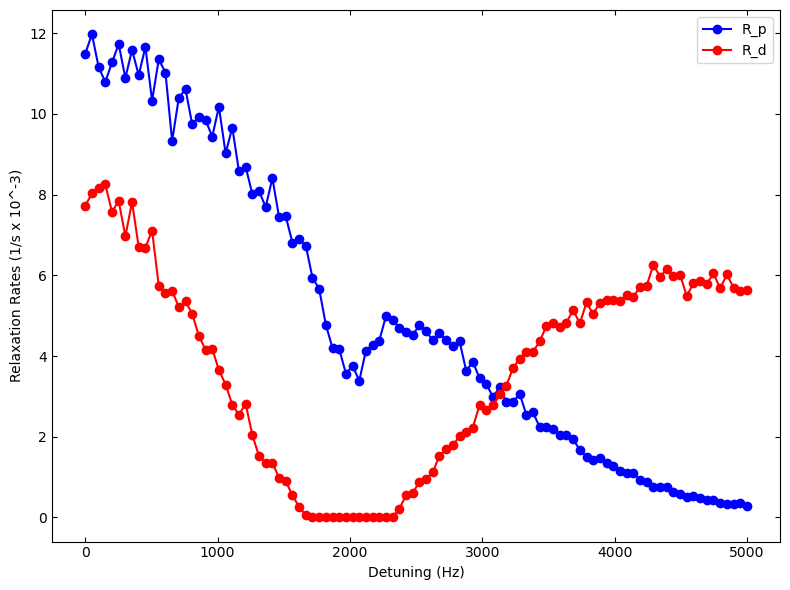

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [49]:
# Load the npz file
data = np.load('OffsetMonteCarlo_100Itr.npz')

# Extract arrays
offset = data['detuning']
stretched_rate = data['S']
mono_rate = data['M']
stretched_avg = data['S_avg']
mono_avg = data['M_avg']

# Infer number of iterations from array shape
iterations = stretched_rate.shape[1]

# Compute error bars
stretched_error = 2*np.sqrt(np.var(stretched_rate, axis=1) / iterations)
mono_error = 2*np.sqrt(np.var(mono_rate, axis=1) / iterations)


fig = plt.figure(figsize=(8, 6))
plt.plot(offset, stretched_avg, '-o', color='blue', label='R_p')
plt.plot(offset, mono_avg, '-o', color='red', label='R_d')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('Detuning (Hz)')
plt.ylabel('Relaxation Rates (1/s x 10^-3)')
# plt.title('Regime III')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


# fig = plt.figure(figsize=(8, 7))
# plt.errorbar(offset, stretched_avg, stretched_error, fmt='-o', color='blue', label='R_p', markersize=6, capsize=3)
# plt.errorbar(offset, mono_avg, mono_error, fmt='-o', color='red', label='R_d', markersize=6, capsize=3)
# plt.tick_params(direction='in')  # for both x and y
# plt.tick_params(top=True, right=True)
# plt.xlabel('Detuning (Hz)')
# plt.ylabel('Relaxation Rates (1/s x 10^-3)')
# # plt.title('Regime III')
# plt.legend()
# # plt.grid(True)
# plt.tight_layout()
# plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\OffsetMonteCarlo.eps", format='eps', dpi=300)